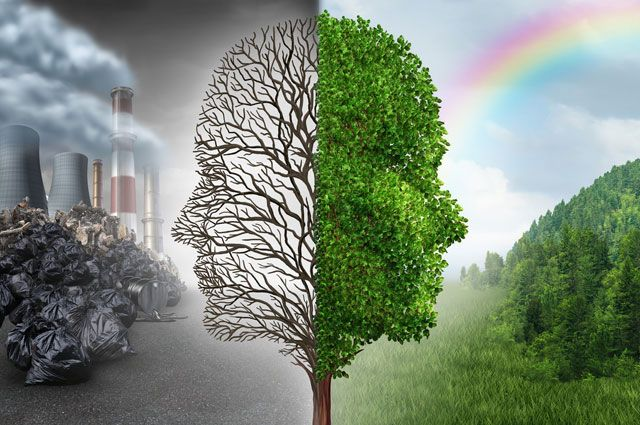

<center>*“As complexity rises, precise statements lose meaning and meaningful statements lose precision”*</center>

<center>Lotfi A. Zadeh (Artificial  Intelligence  expert  and  father  of Fuzzy  Mathematical  Logic)</center>

### [Introduction](#intro)

### [Methodology](#method)

### [Data Preprocessing](#data)

### [Clustering model](#cluster)

### [Analysis and visualizations](#analysis)

### [Conclusion and KPI proposal](#kpi)

### Introduction <a class="anchor" id="intro"></a>

The objective of this study is to identify patterns in the data supplied by Corporations in Climate2020 Survey conducted by CDP and to conjecture useful performance indicator related to sustainability goals.


CDP made available surveyed data on 980 organizations with official registration licenses in United States and Canada. Sample also includes multinationals that report data for their global operations. The reporting period of disclosure varies among participants but majority cover 2019.

*Disclosure of information*

To stress the importance of sustainability reporting it suffices to cite United nations goal on Sustainable Development Goals (SDG2030) that includes target on information disclosure:

| Goal 12:          | Ensure sustainable consumption and production patterns                                                                                                                   |
|-------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Target 12.6:      | Encourage companies, especially large and transnational companies, to adopt sustainable practices and to integrate sustainability information into their reporting cycle |
| Indicator 12.6.1: | Number of companies publishing sustainability reports                                                                                                                    |

### Methodology <a class='anchor' id='method'></a>

The work consists of four steps:

1. Data cleaning and preprocessing

2. Applying unsupervised clustering algorithm to identify similar groups

3. Analysis of partitioned data 

4. Key findings and derivation of KPI


The driving hypothesis: As it stands information reported by corporations is not verified for accuracy, therefore use of absolute figures from supplied data to formulate performance measures is not optimal. Instead my goal is to identify a verifiable and measurable proxy. By analysing data from similar groups it might be possible to deduce common features of 'decarbonization commitment'. 

After considering other clustering methods, I have decided to use Fuzzy C-means clustering. 


References:

https://www.sciencedirect.com/science/article/abs/pii/S0020025519307194

https://www.researchgate.net/publication/221460808_What_Is_Fuzzy_about_Fuzzy_Clustering_Understanding_and_Improving_the_Concept_of_the_Fuzzifier

https://dspace.cvut.cz/bitstream/handle/10467/85075/F2-BP-2019-Bystricky-Krystof-ClusteringMethodsForDataAnalysis.pdf?sequence=-1&isAllowed=y

https://pythonhosted.org/scikit-fuzzy/

### Data Preprocessing <a class="anchor" id="data"></a>

- Import Libraries

- Load (truncated) dataset

- Data Summarization

- Helper functions and dictionaries

- Data extraction for each main question, cleaning and mapping

- Data Preprocessing Output

###  <span style='color: #001A8C'>Import Libraries</span>

In [ ]:
!pip install -U scikit-fuzzy

In [ ]:
## utilities
import os
import pandas as pd
#pd.options.display.float_format = '{:.2f}'.format # to supress scientific notation
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.2f}'.format(x)
pd.set_option('max_colwidth', 150)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math
from collections import Counter
import itertools
import random  
import re
from random import sample

## visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
#import joypy


## clustering and decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
#!pip install -U scikit-fuzzy
import skfuzzy as fuzz

## text analysis (maybe)
# !pip install yake
#import yake # keyword extractor, unsupervised
#from PIL import Image
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import re

###  <span style='color: #001A8C'>Load data (truncated)</span>

In [ ]:
PATH = '../input/cdp-unlocking-climate-solutions'

corp_dc_cl_2020_clean = \
    pd.read_csv(PATH + '/Corporations/Corporations Disclosing/Climate Change/2020_Corporates_Disclosing_to_CDP_Climate_Change.csv',
                usecols=['account_number',
                         'organization',
                         'country',
                         'selected_tier',
                         'authority_types',
                         'activities',
                         'sectors',
                         'industries',
                         'primary_activity',
                         'primary_sector',
                         'primary_industry',
                         'primary_questionnaire_sector',
                         'tickers'], 
                low_memory=False)

r_corp_cl_2020_clean = \
    pd.read_csv(PATH + '/Corporations/Corporations Responses/Climate Change/2020_Full_Climate_Change_Dataset.csv',
                usecols =['account_number',
                          'module_name',
                          'question_number',
                          'question_unique_reference',
                          'column_number',
                          'column_name',
                          'row_number',
                          'row_name',
                          'response_value'],
                low_memory=False)

###  <span style='color: #001A8C'>Data Summarization</span>

In [ ]:
## Corporations disclosing ##
corp_dc_cl_2020_clean.info()

In [ ]:
## Corporates Responses ##
r_corp_cl_2020_clean.info()

In [ ]:
print((609745-340766)/609745 * 100 , '% of NAN rows in response_value')

In [ ]:
## Understand hearchy of data

## Extract List of all QUESTIONS/TOPICS, 
## show to which module QUESTION belongs
## how many rows of response_value it takes
## how many of those rows are empty

summary = \
    r_corp_cl_2020_clean \
        [r_corp_cl_2020_clean \
             ['response_value'].isnull()]\
        .question_unique_reference.value_counts() \
        .rename_axis('question_unique_reference') \
        .reset_index(name='NAN_rows')

## create {question:module} dictionary 
question_module_dict = \
    r_corp_cl_2020_clean \
        .set_index('question_unique_reference')\
        .to_dict()['module_name']

## create {column:question} dictionary
column_question_dict = \
    r_corp_cl_2020_clean\
        .set_index('question_unique_reference')\
        .to_dict()['question_number']


## insert module for each Question in summary 
summary.insert(0,
            'module_name', 
               summary['question_unique_reference'] \
                   .map(question_module_dict))

## insert module for each Question in summary 
summary.insert(1,
            'question_number', 
               summary['question_unique_reference'] \
                   .map(column_question_dict))

## calculate number of rows taken by each Question
all_rows = r_corp_cl_2020_clean\
        .question_unique_reference\
            .value_counts() \
            .rename_axis('question_unique_reference') \
            .reset_index(name='all_rows')
## add to summary
summary = summary.merge(all_rows)

summary['%_NAN_rows'] = \
    (summary['NAN_rows'] / summary['all_rows'] *100)\
        .apply(lambda x: round(x))

## sort by module
summary.sort_values(by=['module_name'], ascending=True)\
    .reset_index()\
    .style.background_gradient(cmap='Wistia',
                               subset=['%_NAN_rows']).set_properties(**{'text-align': 'left'})

In [ ]:
## to deal with sparsity and to facilitate EDA, 
## reshape data into 980 rows(accounts) x columns (feature)

## write helper functions

###  <span style='color: #001A8C'>Helper functions and dictionaries</span>

In [ ]:
modules = list(r_corp_cl_2020_clean.module_name.unique())
question_number  = []
question_unique_reference = []
datasets_dictionary = {}

for m in modules:
    qn = r_corp_cl_2020_clean\
        [r_corp_cl_2020_clean['module_name']==m]\
        .question_number.unique()
    question_number.append(qn)
    qu = r_corp_cl_2020_clean\
        [r_corp_cl_2020_clean['module_name']==m]\
        .question_unique_reference.unique()
    question_unique_reference.append(qu)
    sub_dictionary = dict(zip(qn, qu))
    datasets_dictionary[m] = sub_dictionary

In [ ]:
sorted(datasets_dictionary.keys())

In [ ]:
## pul data for question of interest 
def PullDataCorpClimate2020(module, question):
    """ 
    This function depends 
    on 'Corporations/CorporationsResponses/
        ClimateChange/2020_Full_Climate_Change_Dataset.csv'
    dataset loaded as <r_corp_cl_2020_clean> dataframe,
    which has to be run first.
    
    module shall be a string selected from generated list
    modules = list(r_corp_cl_2020_clean.module_name.unique()).
    
    question shall be a string, selected KEY from composed 
    nested dictionary:
    datasets_dictionary[module].
    
    Returns subset from <r_corp_cl_2020_clean> dataframe 
    for question of interest
    
    requires pandas as pd
    """
    temp = r_corp_cl_2020_clean\
        [(r_corp_cl_2020_clean['module_name']==module) &
         (r_corp_cl_2020_clean['question_number']==question)]\
    .drop(['module_name','question_number',
           'column_number'], axis=1)
    if len(temp['column_name'].value_counts())==1:
        temp = temp.drop(['column_name'], axis=1)
    #if temp.row_number.unique()[0]==0:
        #temp = temp.drop(['row_number'], axis=1)
    if pd.isnull(temp.row_name.unique()[0]):
        temp = temp.drop(['row_name'], axis=1)
    response_name = temp.question_unique_reference.unique()[0]\
                .replace("-","_").replace("/","_")\
                .replace("&","_")\
                .replace(".","").replace("(","")\
                .replace(")","").replace(",","")\
                .replace("and","").replace(" ","_")
    temp = temp.rename({'response_value': response_name}, 
                       axis=1)\
    .drop(['question_unique_reference'], axis=1)
    
    ## add meta data from corporate disclosing dataset
    temp2 = corp_dc_cl_2020_clean[['account_number', 
                                   'organization', 
                                   'country',
                                   'primary_activity',
                                   'primary_industry',
                                   'tickers']]
    
    result = pd.merge(temp2, temp, on="account_number")
    
    
    return result

In [ ]:
## Reshape dataset
def DatasetReshape(dataset):
    """
    When pulled subset is in 'long form',
    it requires further reshaping.
    dataset - result from PullDataCorpClimate2020 function
    """
    
    dfs = []
    ## extract subsets and store in dfs list
        
    for col in sorted(dataset.column_name.unique()):
        tempcol = dataset[dataset['column_name']== col]
        tempcol = tempcol.rename({tempcol.columns[-1]: col}, axis=1)

        if 'row_name' not in tempcol:
            if 'row_number' not in tempcol:
                tempcol = tempcol.drop(['column_name'], axis=1)
                dfs.append(tempcol)
            else:
                for row in sorted(tempcol.row_number.unique()):
                    temprow = tempcol[tempcol['row_number']== row]
                    temprow = temprow.rename({temprow.columns[-1]:
                                              temprow.columns[-1] + "_" + str(row)}, axis=1)
                    temprow = temprow.drop(['column_name','row_number'], axis=1)
                    dfs.append(temprow)
        else:
            for row in sorted(tempcol.row_name.unique()):
                temprow = tempcol[tempcol['row_name']== row]
                temprow = temprow.rename({temprow.columns[-1]:
                                          temprow.columns[-1] + "_" + row}, axis=1)
                temprow = temprow.drop(['column_name', 'row_number', 'row_name'], axis=1)
                dfs.append(temprow)
                
    ## merge all dfs in one wide table 
    result = pd.DataFrame(corp_dc_cl_2020_clean[['account_number']])
    
    if 'row_name' not in dataset:
        if 'row_number' not in dataset:
             dfs_number = len(dataset.column_name.unique())
        else:
            dfs_number = len(dataset.column_name.unique()) * len(dataset.row_number.unique())
    else:
        dfs_number = len(dataset.column_name.unique()) * len(dataset.row_name.unique())

    for n in range(dfs_number):
         result = pd.merge(result,
                           dfs[n][['account_number',dfs[n].columns[-1]]],
                           on='account_number',
                           how='left')

    ## add columns [organization, primary activity]
    result = pd.merge(corp_dc_cl_2020_clean[['account_number',
                                         'organization',
                                         'primary_activity',
                                         'primary_industry']],
                                   result, 
                                   on='account_number')

    ## if there are columns with more than 90% NA, drop
    #result = \
        #result.dropna(thresh=98, axis=1, how='all')

    return result

In [ ]:
## Reshape dataset IF COLUMNS are none
def DatasetReshape2(dataset):
    """
    When pulled subset is in 'long form',
    it requires further reshaping.
    dataset - result from PullDataCorpClimate2020 function
    """
    
    dfs = []
    ## extract subsets and store in dfs list
    
    if 'row_name' not in dataset:
        for row in sorted(dataset.row_number.unique()):
            temprow = dataset[dataset['row_number'] == row]
            temprow = temprow.rename({temprow.columns[-1]:
                                      temprow.columns[-1] + "_" + str(row)}, axis=1)
            temprow = temprow.drop(['row_number'], axis=1)
            dfs.append(temprow)
    else:
        for row in sorted(dataset.row_name.unique()):
            temprow = dataset[dataset['row_name']== row]
            temprow = temprow.rename({temprow.columns[-1]:
                                      temprow.columns[-1] + "_" + row}, axis=1)
            temprow = temprow.drop(['row_number', 'row_name'], axis=1)
            dfs.append(temprow)
                
    ## merge all dfs in one wide table 
    result = pd.DataFrame(corp_dc_cl_2020_clean[['account_number']])
    
    dfs_number =len(dataset.row_number.unique())

    for n in range(dfs_number):
         result = pd.merge(result,
                           dfs[n][['account_number',dfs[n].columns[-1]]],
                           on='account_number',
                           how='left')

    ## add columns [organization, primary activity]
    result = pd.merge(corp_dc_cl_2020_clean[['account_number',
                                         'organization',
                                         'primary_activity',
                                         'primary_industry']],
                                   result, 
                                   on='account_number')

    ## if there are columns with more than 90% NA, drop
    #result = \
        #result.dropna(thresh=98, axis=1, how='all')

    return result

**How -  to use dictionary and function to pull data from the main dataframe**
*(energy module as an example)*

1. Run all above cells: imports, data loading, dictionaries and helper functions
2. Run **datasets_dictionary.keys()** to get exact name of section (module) of interest
3. Run **datasets_dictionary['C8. Energy'].keys()** to get Question Numbers for each table in the section
4. Run **datasets_dictionary['C8. Energy']['C8.1']** to read a Question/ subject of responses and choose one of interest
5. Run **PullDataCorpClimate2020('C8. Energy','C8.1')** to pull data related to section/question of analysis
6. If pulled df is NOT in 'one record per account (980 rows) form' still, one can use DatasetReshape()to reshape
7. Concatenate resultant subsets via mapping progressivly into one final table of important features - output of this section.

### <span style='color: #001A8C'>Data extraction for each main question</span>

### Corporations in dataset<a class="anchor" id="2"></a>

1. Description 

2. Reporting period

3. Countries(multinational operations) covered

4. Currency used in report

5. Reporting boundary

#### Base - corporate metadata

In [ ]:
corporations2020 = corp_dc_cl_2020_clean

## This is the base, to which
## other features/columns will be
## progressively mapped to
## complete data representation

#### <span style='color:#808000'>C0. Introduction</span>

In [ ]:
datasets_dictionary['C0. Introduction']

**'C0.1': 'Give a general description and introduction to your organization.'**

In [ ]:
## pull data related to the Question
general = \
    PullDataCorpClimate2020('C0. Introduction','C0.1')

#general.info()
general = general.drop('row_number', axis=1)

general.head(2)

In [ ]:
## Mapping this categorical feature 1
## tickers
## if no ticker - 0
## if ticker - 1
general['Listed'] = \
    np.where((general\
              ['tickers'].isnull()), 0, 1)

## 1st mapped value
mapping_listed = dict(general[['account_number', 'Listed']].values)

**'C0.2': 'State the start and end date of the year for which you are reporting data.'**

In [ ]:
## pull data related to the Question
reporting_period = \
    PullDataCorpClimate2020('C0. Introduction','C0.2')

## reshape
reporting_period_reshaped = DatasetReshape(reporting_period)

## change to date formtat
reporting_period_reshaped[reporting_period_reshaped.columns[4]] = \
    pd.to_datetime(reporting_period_reshaped\
             [reporting_period_reshaped.columns[4]], 
                   format='%Y-%m-%d')

## plot
reporting_period_reshaped\
      [reporting_period_reshaped.columns[4]].value_counts().\
      to_frame().plot();

In [ ]:
## Mapping this categorical feature 2
## C0.2_C1Start date_Reporting year
## if no response - 0
## if different from optimal - 1
## if optimal report starts 2019-01 - 2
reporting_period_reshaped['Year_2019'] = \
    np.where((reporting_period_reshaped\
              ['C0.2_C1Start date_Reporting year']=='2019-01-01'),
             2, 1)

#reporting_period_reshaped.head()

In [ ]:
## 2nd mapped value
mapping_report_year = dict(reporting_period_reshaped[['account_number', 'Year_2019']].values)

In [ ]:
## Mapping this categorical feature 3
## C0.2_C3Indicate if you are providing emissions data for past reporting years_Reporting year
## if no response - 0
## if No - 1
## if Yes - 2

conditions3 = [
    (reporting_period_reshaped\
     ['C0.2_C3Indicate if you are providing emissions data for past reporting years_Reporting year']\
         .isnull()),
    (reporting_period_reshaped\
     ['C0.2_C3Indicate if you are providing emissions data for past reporting years_Reporting year']=='No'),
    (reporting_period_reshaped\
    ['C0.2_C3Indicate if you are providing emissions data for past reporting years_Reporting year']=='Yes')]
values3 = [0,1,2]

reporting_period_reshaped['PastYearData'] = np.select(conditions3,values3)

## 3d mapped value
mapping_past_year_data = dict(reporting_period_reshaped\
                              [['account_number', 'PastYearData']].\
                              values)

**'C0.3': 'Select the countries/areas for which you will be supplying data.'**

In [ ]:
## pull data related to the section Question
countries_covered = \
    PullDataCorpClimate2020('C0. Introduction',
                            'C0.3')

#countries_covered.head()

In [ ]:
## Mapping this categorical feature 4
## Select_the_countries_areas_for_which_you_will_be_supplying_data
## no response - 0
## if Single country - 1
## if Multinational - 2

conditions4 = [(countries_covered['Select_the_countries_areas_for_which_you_will_be_supplying_data'].isnull()),
               (countries_covered['Select_the_countries_areas_for_which_you_will_be_supplying_data']=='Canada'),
               (countries_covered['Select_the_countries_areas_for_which_you_will_be_supplying_data']=='United States of America'),
               (countries_covered['Select_the_countries_areas_for_which_you_will_be_supplying_data']!='Canada'),
               (countries_covered['Select_the_countries_areas_for_which_you_will_be_supplying_data']!='United States of America')]

values4 = [0,1,1,2,2]

countries_covered['Multinational'] = np.select(conditions4, values4)

mapping_multinational = \
    dict(countries_covered[['account_number',
                            'Multinational']].values)

**'C0.4': 'Select the currency used for all financial information disclosed throughout your response.'**

In [ ]:
## pull data related to the section Question
currency = \
    PullDataCorpClimate2020('C0. Introduction','C0.4')
#currency[currency.columns[-1]].value_counts().to_frame()

In [ ]:
## Mapping this categorical feature 5
## Select_the_currency_used_for_all_financial_information_disclosed_throughout_your_response
## if USD or CAD - 2
## if Other - 1

conditions5 = [(currency['Select_the_currency_used_for_all_financial_information_disclosed_throughout_your_response']=='USD'),
               (currency['Select_the_currency_used_for_all_financial_information_disclosed_throughout_your_response']=='CAD'),
               (currency['Select_the_currency_used_for_all_financial_information_disclosed_throughout_your_response']!='USD'),
              (currency['Select_the_currency_used_for_all_financial_information_disclosed_throughout_your_response']!='CAD')]

values5 = [2,2,1,1]

currency['Currency'] = np.select(conditions5, values5)

mapping_currency = \
    dict(currency[['account_number',
                            'Currency']].values)

**'C0.5': 'Select the option that describes the reporting boundary for which climate-related impacts on your business are being reported.**

In [ ]:
## pull data related to the section Question
reporting_boundary = \
    PullDataCorpClimate2020('C0. Introduction','C0.5')

#reporting_boundary.info()

In [ ]:
## Mapping this categorical feature 6
## Select the option that describes the reporting boundary for which climate-related impacts on your business are being reported
## if Operational control - 3
## if Financial control - 2
## if Equity share - 1
## if NAN - 0

conditions6 = [(reporting_boundary[reporting_boundary.columns[-1]]=='Operational control'),
               (reporting_boundary[reporting_boundary.columns[-1]]=='Financial control'),
               (reporting_boundary[reporting_boundary.columns[-1]]=='Equity share'),
               (reporting_boundary[reporting_boundary.columns[-1]].isnull())]

values6 = [3,2,1,0]

reporting_boundary['Reporting_boundary'] = np.select(conditions6,values6)

mapping_boundary = \
    dict(reporting_boundary[['account_number',
                            'Reporting_boundary']].values)

#### <span style='color:#808000'>C2. Risks and opportunities</span>

C2.1a': 'How does your organization define short-, medium- and long-term time horizons?

In [ ]:
## pull data related to the section Question
time_horizons = \
    PullDataCorpClimate2020('C2. Risks and opportunities','C2.1a')

#time_horizons.info()

##need to reshape
time_horizons_reshaped = \
    DatasetReshape(time_horizons)

##concatenate col for each range (short,mid,long)
time_horizons_reshaped['Short_term'] = \
    time_horizons_reshaped[time_horizons_reshaped.columns[6]] \
    +'-'+ \
    time_horizons_reshaped[time_horizons_reshaped.columns[9]]

time_horizons_reshaped['Medium_term'] = \
    time_horizons_reshaped[time_horizons_reshaped.columns[5]] \
    +'-'+ \
    time_horizons_reshaped[time_horizons_reshaped.columns[8]]

time_horizons_reshaped['Long_term'] = \
    time_horizons_reshaped[time_horizons_reshaped.columns[4]] \
    +'-'+ \
    time_horizons_reshaped[time_horizons_reshaped.columns[7]]

time_horizons_reshaped = \
    time_horizons_reshaped.drop(['C2.1a_C1From (years)_Long-term',
                                 'C2.1a_C1From (years)_Medium-term',
                                 'C2.1a_C1From (years)_Short-term',
                                 'C2.1a_C2To (years)_Long-term',
                                 'C2.1a_C2To (years)_Medium-term',
                                 'C2.1a_C2To (years)_Short-term'],
                                axis=1)
#time_horizons_reshaped.head()

## Mapping this categorical feature 7
## How does your organization define short-, medium- and long-term time horizons?
## if responded to question - 1
## if not responded - 0

time_horizons_reshaped['ShortTerm'] = np.where((time_horizons_reshaped['Short_term'].isnull()),0,1)
time_horizons_reshaped['MediumTerm'] = np.where((time_horizons_reshaped['Medium_term'].isnull()),0,1)
time_horizons_reshaped['LongTerm'] = np.where((time_horizons_reshaped['Long_term'].isnull()),0,1)

mapping_short_term_defined = \
    dict(time_horizons_reshaped[['account_number',
                            'ShortTerm']].values)

mapping_medium_term_defined = \
    dict(time_horizons_reshaped[['account_number',
                            'MediumTerm']].values)

mapping_long_term_defined = \
    dict(time_horizons_reshaped[['account_number',
                            'LongTerm']].values)

**C2.2:Describe your process(es) for identifying, assessing and responding to climate-related risks and opportunities.**

In [ ]:
## pull data related to the section Question
risks_id_processes = \
    PullDataCorpClimate2020('C2. Risks and opportunities','C2.2')

## reshape 
risks_id_processes_reshaped = \
    DatasetReshape(risks_id_processes)

#risks_id_processes_reshaped.head()

## Mapping this categorical feature 8
## Describe your process(es) for identifying, assessing and responding to climate-related risks and opportunities
## if specific climate-related risk management process - 2
## if itegrated - 1
## if no response = 0

conditions8 = [(risks_id_processes_reshaped['C2.2_C2Risk management process_1']=='A specific climate-related risk management process'),
              (risks_id_processes_reshaped['C2.2_C2Risk management process_1']=='Integrated into multi-disciplinary company-wide risk management process'),
              (risks_id_processes_reshaped['C2.2_C2Risk management process_1'].isnull())]

values8 = [2,1,0]

risks_id_processes_reshaped['RiskManagementProcess'] = np.select(conditions8,values8)

mapping_rmp = \
    dict(risks_id_processes_reshaped[['account_number',
                            'RiskManagementProcess']].values)

**C2.2a': "Which risk types are considered in your organization's climate-related risk assessments?"**

In [ ]:
## pull data related to the section Question
types_of_risks = \
    PullDataCorpClimate2020('C2. Risks and opportunities',
                            'C2.2a')
## check structure
#types_of_risks.info()

## reshape 
types_of_risks_reshaped = \
    DatasetReshape(types_of_risks)

#types_of_risks_reshaped.head()

## Mapping this categorical feature 9 - 16
## Risks Relevance & inclusion
## Relevant, always included = 3
## Not relevant, included = 3
## Relevant, sometimes included = 2
## Relevant, not included = 1
## Not relevant, explanation provided = 1
## Not evaluated = 1
## nan = 0

#Acute physical
conditions9 = [(types_of_risks_reshaped[types_of_risks_reshaped.columns[4]]=='Relevant, always included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[4]]=='Not relevant, included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[4]]=='Relevant, sometimes included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[4]]=='Relevant, not included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[4]]=='Not relevant, explanation provided'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[4]]=='Not evaluated'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[4]].isnull())]
                
values9 = [3,3,2,1,2,1,0]
   
types_of_risks_reshaped['AcutephysicalRisk'] = np.select(conditions9,values9)

# Chronic physical
conditions10 = [(types_of_risks_reshaped[types_of_risks_reshaped.columns[5]]=='Relevant, always included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[5]]=='Not relevant, included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[5]]=='Relevant, sometimes included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[5]]=='Relevant, not included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[5]]=='Not relevant, explanation provided'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[5]]=='Not evaluated'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[5]].isnull())]
                
values10 = [3,3,2,1,2,1,0]

types_of_risks_reshaped['ChronicPhysicalRisk'] = np.select(conditions10,values10)


# Current regulation
conditions11 = [(types_of_risks_reshaped[types_of_risks_reshaped.columns[6]]=='Relevant, always included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[6]]=='Not relevant, included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[6]]=='Relevant, sometimes included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[6]]=='Relevant, not included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[6]]=='Not relevant, explanation provided'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[6]]=='Not evaluated'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[6]].isnull())]
                
values11 = [3,3,2,1,2,1,0]

types_of_risks_reshaped['CurrentRegulationRisk'] = np.select(conditions11,values11)


# Emerging regulation
conditions12 = [(types_of_risks_reshaped[types_of_risks_reshaped.columns[7]]=='Relevant, always included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[7]]=='Not relevant, included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[7]]=='Relevant, sometimes included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[7]]=='Relevant, not included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[7]]=='Not relevant, explanation provided'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[7]]=='Not evaluated'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[7]].isnull())]
                
values12 = [3,3,2,1,2,1,0]

types_of_risks_reshaped['EmergingRegulationRisk'] = np.select(conditions12,values12)

# Legal
conditions13 = [(types_of_risks_reshaped[types_of_risks_reshaped.columns[8]]=='Relevant, always included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[8]]=='Not relevant, included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[8]]=='Relevant, sometimes included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[8]]=='Relevant, not included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[8]]=='Not relevant, explanation provided'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[8]]=='Not evaluated'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[8]].isnull())]
                
values13 = [3,3,2,1,2,1,0]

types_of_risks_reshaped['LegalRisk'] = np.select(conditions13,values13)

# Market
conditions14 = [(types_of_risks_reshaped[types_of_risks_reshaped.columns[9]]=='Relevant, always included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[9]]=='Not relevant, included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[9]]=='Relevant, sometimes included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[9]]=='Relevant, not included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[9]]=='Not relevant, explanation provided'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[9]]=='Not evaluated'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[9]].isnull())]
                
values14 = [3,3,2,1,2,1,0]

types_of_risks_reshaped['MarketRisk'] = np.select(conditions14,values14)

# Reputation
conditions15 = [(types_of_risks_reshaped[types_of_risks_reshaped.columns[10]]=='Relevant, always included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[10]]=='Not relevant, included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[10]]=='Relevant, sometimes included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[10]]=='Relevant, not included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[10]]=='Not relevant, explanation provided'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[10]]=='Not evaluated'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[10]].isnull())]
                
values15 = [3,3,2,1,2,1,0]

types_of_risks_reshaped['ReputationRisk'] = np.select(conditions15,values15)


# Technology
conditions16 = [(types_of_risks_reshaped[types_of_risks_reshaped.columns[11]]=='Relevant, always included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[11]]=='Not relevant, included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[11]]=='Relevant, sometimes included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[11]]=='Relevant, not included'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[11]]=='Not relevant, explanation provided'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[11]]=='Not evaluated'),
                (types_of_risks_reshaped[types_of_risks_reshaped.columns[11]].isnull())]
                
values16 = [3,3,2,1,2,1,0]

types_of_risks_reshaped['TechnologyRisk'] = np.select(conditions16,values16)


In [ ]:
mapping_acute_physical_risk = \
    dict(types_of_risks_reshaped[['account_number',
                            'AcutephysicalRisk']].values)

mapping_chronic_physical_risk = \
    dict(types_of_risks_reshaped[['account_number',
                            'ChronicPhysicalRisk']].values)

mapping_current_regulation_risk = \
    dict(types_of_risks_reshaped[['account_number',
                            'CurrentRegulationRisk']].values)

mapping_emerging_regulation_risk = \
    dict(types_of_risks_reshaped[['account_number',
                            'EmergingRegulationRisk']].values)

mapping_legal_risk = \
    dict(types_of_risks_reshaped[['account_number',
                            'LegalRisk']].values)

mapping_market_risk = \
    dict(types_of_risks_reshaped[['account_number',
                            'MarketRisk']].values)

mapping_reputation_risk = \
    dict(types_of_risks_reshaped[['account_number',
                            'ReputationRisk']].values)

mapping_technology_risk = \
    dict(types_of_risks_reshaped[['account_number',
                            'TechnologyRisk']].values)

**C2.3': 'Have you identified any inherent climate-related risks with the potential to have a substantive financial or strategic impact on your business?**

In [ ]:
## pull data related to the section Question
identified_impacts = \
    PullDataCorpClimate2020('C2. Risks and opportunities',
                            'C2.3')

identified_impacts.head()

## Mapping this categorical feature 17
## Have you identified any inherent climate-related risks
## Yes - 2
## No - 1
## Nan - 0

conditions17 = [(identified_impacts[identified_impacts.columns[-1]]=='Yes'),
               (identified_impacts[identified_impacts.columns[-1]]=='No'),
               (identified_impacts[identified_impacts.columns[-1]].isnull())]

values17 = [2,1,0]

identified_impacts['IdentifiedRiskImpact'] = np.select(conditions17, values17)

mappig_risk_impacts = dict(identified_impacts[['account_number',
                                              'IdentifiedRiskImpact']].values)

**C2.3a': 'Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business.**

In [ ]:
## pull data related to the section Question
identified_risks = \
    PullDataCorpClimate2020('C2. Risks and opportunities',
                            'C2.3a')
## check structure
#identified_risks.info()

## reshape 
identified_risks_reshaped = \
    DatasetReshape(identified_risks)

#identified_risks_reshaped.head()

## Mapping this categorical feature 18
## Are you able to provide a potential financial impact figure?
## Yes - 2
## No - 1
## Nan - 0
conditions18 = [(identified_risks_reshaped[identified_risks_reshaped.columns[5]]=='Yes, an estimated range'),
               (identified_risks_reshaped[identified_risks_reshaped.columns[5]]=='Yes, a single figure estimate'),
               (identified_risks_reshaped[identified_risks_reshaped.columns[5]]=='No, we do not have this figure'),
               (identified_risks_reshaped[identified_risks_reshaped.columns[5]].isnull())]

values18 = [2, 2, 1, 0]

identified_risks_reshaped['Risk1PotentialFinancialImpact'] = np.select(conditions18,values18)

mapping_risk_financial_impact = dict(identified_risks_reshaped[['account_number',
                                                                'Risk1PotentialFinancialImpact']].values)

**C2.4': 'Have you identified any climate-related opportunities with the potential to have a substantive financial or strategic impact on your business?**

In [ ]:
identified_opportunities = \
    PullDataCorpClimate2020('C2. Risks and opportunities',
                            'C2.4')
#identified_opportunities.head(1)

## Mapping this categorical feature 19
## Have_you_identified_any_climate_related_opportunities?
## Yes - 2
## No - 1
## Nan - 0
conditions19 = [(identified_opportunities[identified_opportunities.columns[-1]]=='Yes'),
               (identified_opportunities[identified_opportunities.columns[-1]]=='No'),
               (identified_opportunities[identified_opportunities.columns[-1]].isnull())]

values19 = [2, 1, 0]

identified_opportunities['IdentifiedOppImpact'] = np.select(conditions19,values19)

mapping_opp_impact = dict(identified_opportunities[['account_number',
                                                                'IdentifiedOppImpact']].values)

**C2.4a': 'Provide details of opportunities identified with the potential to have a substantive financial or strategic impact on your business.**

In [ ]:
details_opportunities = \
    PullDataCorpClimate2020('C2. Risks and opportunities',
                            'C2.4a')
## check structure
## reshape 
details_opportunities_reshaped = \
    DatasetReshape(details_opportunities)

#details_opportunities_reshaped.head(2)

## Mapping this categorical feature 20
## Are you able to provide a potential financial impact figure?
## Yes - 2
## No - 1
## Nan - 0
conditions20 = [(details_opportunities_reshaped[details_opportunities_reshaped.columns[5]]=='Yes, a single figure estimate'),
               (details_opportunities_reshaped[details_opportunities_reshaped.columns[5]]=='Yes, an estimated range'),
               (details_opportunities_reshaped[details_opportunities_reshaped.columns[5]]=='No, we do not have this figure'),
               (details_opportunities_reshaped[details_opportunities_reshaped.columns[5]].isnull())]

values20 = [2, 2, 1, 0]

details_opportunities_reshaped['Risk1PotentialFinancialImpact'] = np.select(conditions20,values20)

mapping_opp_financial_impact = dict(details_opportunities_reshaped[['account_number',
                                                                'Risk1PotentialFinancialImpact']].values)

#### <span style='color:#808000'>C4. Targets and performance</span>

In [ ]:
datasets_dictionary['C4. Targets and performance']

In [ ]:
## pull data related to the section Question
emission_targets_setting = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.1')

#emission_targets_setting.head()

## Mapping this categorical feature 21
## Did_you_have_an_emissions_target_that_was_active_in_the_reporting_year?
## Absolute target, Intensity target,Both absolute and intensity targets - 2
## No target - 1
## Nan - 0

conditions21 = [(emission_targets_setting[emission_targets_setting.columns[-1]]=='Absolute target'),
                (emission_targets_setting[emission_targets_setting.columns[-1]]=='Intensity target'),
                (emission_targets_setting[emission_targets_setting.columns[-1]]=='Both absolute and intensity targets'),
                (emission_targets_setting[emission_targets_setting.columns[-1]]=='No target'),
                (emission_targets_setting[emission_targets_setting.columns[-1]].isnull())]
                
values21 = [2, 2, 2, 1, 0]    

emission_targets_setting['EmissionTargetSetting'] = np.select(conditions21, values21)

mapping_emission_target_setting = dict(emission_targets_setting[['account_number',
                                                                 'EmissionTargetSetting']].values)

**C4.1a': 'Provide details of your absolute emissions target(s) and progress made against those targets.**

In [ ]:
## pull data related to the section Question
emission_targets_details = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.1a')
## check structure
#emission_targets_details.info()

## reshape
emission_targets_details_reshaped = \
    DatasetReshape(emission_targets_details)

#emission_targets_details_reshaped.head(1)

## Mapping this categorical feature 22
## C4.1a_C13Target status in reporting year_1

## convert to numerical, replace NAN with 0
emission_targets_details_reshaped\
    ['C4.1a_C9Targeted reduction from base year (%)_1'] = \
        pd.to_numeric(emission_targets_details_reshaped\
                    ['C4.1a_C9Targeted reduction from base year (%)_1']).\
                        fillna(0)

## numerical value, mapping without encoding

mapping_emission_target1_reduction = \
    dict(emission_targets_details_reshaped[['account_number',
                                        'C4.1a_C9Targeted reduction from base year (%)_1']].values)

## Mapping this categorical feature 23
## Underway - 2
## Achieved - 3 
## New -2
## Revised -1
## Replaced -1
## Expired -1
## Retired -1
## NAN - 0 

conditions23 = [(emission_targets_details_reshaped['C4.1a_C13Target status in reporting year_1']=='Underway'),
                (emission_targets_details_reshaped['C4.1a_C13Target status in reporting year_1']=='Achieved'),
                (emission_targets_details_reshaped['C4.1a_C13Target status in reporting year_1']=='New'),
                (emission_targets_details_reshaped['C4.1a_C13Target status in reporting year_1']=='Revised'),
                (emission_targets_details_reshaped['C4.1a_C13Target status in reporting year_1']=='Replaced'),
                (emission_targets_details_reshaped['C4.1a_C13Target status in reporting year_1']=='Expired'),
                (emission_targets_details_reshaped['C4.1a_C13Target status in reporting year_1']=='Retired'),
                (emission_targets_details_reshaped['C4.1a_C13Target status in reporting year_1'].isnull())]

values23 = [2, 3, 2, 1, 1, 1, 1, 0]

emission_targets_details_reshaped['Target1Status'] = np.select(conditions23, values23)

mapping_target1_status = dict(emission_targets_details_reshaped[['account_number',
                                                                 'Target1Status']].values)

**C4.1b': 'Provide details of your emissions intensity target(s) and progress made against those target(s).**

In [ ]:
## pull data related to the section Question
intensity_targets = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.1b')
## reshape
intensity_targets_reshaped = \
    DatasetReshape(intensity_targets)
#intensity_targets_reshaped.head(1)

## Mapping this categorical feature 24
## C4.1b_C10Targeted reduction from base year (%)_1

intensity_targets_reshaped['C4.1b_C10Targeted reduction from base year (%)_1'] = \
    pd.to_numeric(intensity_targets_reshaped['C4.1b_C10Targeted reduction from base year (%)_1']).\
    fillna(0)

mapping_intensity_targeted_reduction = dict(intensity_targets_reshaped[['account_number',
                                            'C4.1b_C10Targeted reduction from base year (%)_1']].values)

**C4.1c': 'Explain why you did not have an emissions target, and forecast how your emissions will change over the next five years.**

In [ ]:
## pull data related to the section Question
no_targets_reason = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.1c')
##reshape
no_targets_reason_reshaped = \
    DatasetReshape(no_targets_reason)

#no_targets_reason_reshaped.head(1)

## Will not map this feature, as 
## already have feature Did You Have a Target
## However this "textual data" 'Please explain' can be useful 
## for text analysis, if time will allow

**C4.2b': 'Provide details of any other climate-related targets, including methane reduction targets.**

In [ ]:
## pull data related to the section Question
other_climate_targets = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.2b')
#other_climate_targets.info()
##reshape
other_climate_targets_reshaped = \
    DatasetReshape(other_climate_targets)

#other_climate_targets_reshaped[other_climate_targets_reshaped.columns[4:40]].info() 76% null
#other_climate_targets_reshaped[other_climate_targets_reshaped.columns[40:80]].info() 76% null
#other_climate_targets_reshaped[other_climate_targets_reshaped.columns[80:120]].info() 76% null
#other_climate_targets_reshaped[other_climate_targets_reshaped.columns[120:148]].info() 76% null

## This feature is extremly sparse, about 76% null value, it might bias outcome 
## for time being will not include it in clustering model

**C4.3': 'Did you have emissions reduction initiatives that were active within the reporting year? Note that this can include those in the planning and/or implementation phases.**

In [ ]:
## pull data related to the section Question
emission_reduction_initiatives = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.3')

#emission_reduction_initiatives.head(1)

## Mapping this categorical feature 25
## Did_you_have_emissions_reduction_initiatives
## Yes - 2
## No - 1
## NAN - 0

conditions25 = [(emission_reduction_initiatives[emission_reduction_initiatives.columns[-1]]=='Yes'),
               (emission_reduction_initiatives[emission_reduction_initiatives.columns[-1]]=='No'),
               (emission_reduction_initiatives[emission_reduction_initiatives.columns[-1]].isnull())]

values25 = [2, 1, 0]

emission_reduction_initiatives['EmissionReductionInitiative'] = np.select(conditions25,
                                                                         values25)
mapping_emission_reduction_initiative = dict(emission_reduction_initiatives[['account_number',
                                                                             'EmissionReductionInitiative']].values)

**C4.3a': 'Identify the total number of initiatives at each stage of development, and for those in the implementation stages, the estimated CO2e savings.**

In [ ]:
## pull data related to the section Question
emission_reduction_initiatives_details = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.3a')

#emission_reduction_initiatives_details.info()

##reshape
emission_reduction_initiatives_details_reshaped =\
    DatasetReshape(emission_reduction_initiatives_details)

#emission_reduction_initiatives_details_reshaped.head()

## Mapping this categorical feature 26
## Number of initiatives commenced

## convert to numerical
emission_reduction_initiatives_details_reshaped\
    ['C4.3a_C1Number of initiatives_Implementation commenced*'] = pd.to_numeric(
emission_reduction_initiatives_details_reshaped\
    ['C4.3a_C1Number of initiatives_Implementation commenced*']).fillna(0)

mapping_no_initiatives_commenced = dict\
    (emission_reduction_initiatives_details_reshaped\
     [['account_number',
       'C4.3a_C1Number of initiatives_Implementation commenced*']].values)

## Mapping this categorical feature 27
## Number of initiatives_Implemented

## convert to numerical
emission_reduction_initiatives_details_reshaped\
    ['C4.3a_C1Number of initiatives_Implemented*'] = pd.to_numeric(
emission_reduction_initiatives_details_reshaped\
    ['C4.3a_C1Number of initiatives_Implemented*']).fillna(0)

mapping_no_initiatives_implemented = dict\
    (emission_reduction_initiatives_details_reshaped\
     [['account_number',
       'C4.3a_C1Number of initiatives_Implemented*']].values)

In [ ]:
## pull data related to the Question
introduction = \
    PullDataCorpClimate2020('C0. Introduction','C0.1')

#introduction.head()

**C4.3b': 'Provide details on the initiatives implemented in the reporting year in the table below.**

In [ ]:
##THIS RUNS LONG
## pull data related to the section Question
implemented_initiatives = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.3b')
#implemented_initiatives.info()

## reshape
implemented_initiatives_reshaped = \
    DatasetReshape(implemented_initiatives)
#implemented_initiatives_reshaped.head()

## This feature to be addressed in Analysis section
## encoding will result in loss of usefull information
## like concreate initiatives taken by organizations

**'C4.3c': 'What methods do you use to drive investment in emissions reduction activities?'**

In [ ]:
## pull data related to the section Question
investment_methods = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.3c')

#investment_methods.info()
investment_methods_reshaped = \
    DatasetReshape(investment_methods)
#investment_methods_reshaped.head()

## This feature to be addressed in Analysis section
## encoding will result in loss of usefull information
## like concreate methods used by organizations

**C4.5': 'Do you classify any of your existing goods and/or services as low-carbon products or do they enable a third party to avoid GHG emissions?**

In [ ]:
## pull data related to the section Question
classify_lowcarbon_output = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.5')
#classify_lowcarbon_output.head()

## Mapping this categorical feature 28
##Do_you_classify_any_of_your_existing_goods__or_services_as_low_carbon_products?
## Yes - 2
## No - 1
## No response - 0

conditions28 = [(classify_lowcarbon_output[classify_lowcarbon_output.columns[-1]]=='Yes'),
                (classify_lowcarbon_output[classify_lowcarbon_output.columns[-1]]=='No'),
                (classify_lowcarbon_output[classify_lowcarbon_output.columns[-1]].isnull())]

values28 = [2, 1, 0]

classify_lowcarbon_output['LowcarbonOutputs'] = np.select(conditions28, values28)

mapping_lowcarbon_output = dict(classify_lowcarbon_output[['account_number','LowcarbonOutputs']].values)

**C4.5a': 'Provide details of your products and/or services that you classify as low-carbon products or that enable a third party to avoid GHG emissions.'**

In [ ]:
## pull data related to the section Question
low_carbon_output = \
    PullDataCorpClimate2020('C4. Targets and performance',
                            'C4.5a')
#low_carbon_output.info()
## reshape
low_carbon_output_reshaped = \
    DatasetReshape(low_carbon_output)

#low_carbon_output_reshaped.head()
## This feature to be addressed in Analysis section
## encoding will result in loss of usefull information
## like concreate low carbon outputs by organizations

#### <span style='color:#808000'>C6. Emissions data</span>

**C6.1': 'What were your organization's gross global Scope 1 emissions in metric tons CO2e?**

In [ ]:
## pull data related to the section Question
emissions = \
    PullDataCorpClimate2020('C6. Emissions data',
                            'C6.1')
## check structure
#emissions.info()

## reshape
emissions_reshaped = \
    DatasetReshape(emissions)

## interested in current reporting year
scope1 = \
    emissions_reshaped[['account_number','organization',
                        'primary_activity','primary_industry',
                        'C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)_Reporting year']]

## change to numerical
scope1[scope1.columns[-1]] = \
        pd.to_numeric(scope1[scope1.columns[-1]]).fillna(0)

#scope1.head()

## Mapping this feature 28
mapping_scope1 = dict(scope1[['account_number',
                              'C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)_Reporting year']].values)

**C6.3': 'What were your organization's gross global Scope 2 emissions in metric tons CO2e?**

In [ ]:
## pull data related to the section Question
emissions2 = \
    PullDataCorpClimate2020('C6. Emissions data',
                            'C6.3')
#emissions2.info()

## reshape
emissions2_reshaped = DatasetReshape(emissions2)
emissions2_reshaped.head()

## interested only in reporting year
scope2 = emissions2_reshaped[['account_number',
                              'organization',
                              'primary_activity',
                              'primary_industry',
                              'C6.3_C1Scope 2, location-based_Reporting year',
                              'C6.3_C2Scope 2, market-based (if applicable)_Reporting year']]
#scope2.head()

## Mapping this feature 29
scope2['C6.3_C1Scope 2, location-based_Reporting year'] = \
    pd.to_numeric(scope2['C6.3_C1Scope 2, location-based_Reporting year']).fillna(0)

mapping_scope2_loc = dict(scope2[['account_number',
                                  'C6.3_C1Scope 2, location-based_Reporting year']].values)

## Mapping this feature 30
scope2['C6.3_C2Scope 2, market-based (if applicable)_Reporting year'] = \
    pd.to_numeric(scope2['C6.3_C2Scope 2, market-based (if applicable)_Reporting year']).fillna(0)

mapping_scope2_mar = dict(scope2[['account_number',
                                  'C6.3_C2Scope 2, market-based (if applicable)_Reporting year']].values)

**C6.5': 'Account for your organization's gross global Scope 3 emissions, disclosing and explaining any exclusions.**

In [ ]:
## pull data related to the section Question
emissions3 = \
    PullDataCorpClimate2020('C6. Emissions data','C6.5')

## check structure
#emissions3.info()

## reshape
emissions3_reshaped = \
    DatasetReshape(emissions3)
emissions3_reshaped.head(1)

## This dataset is less informative than actual information
## about scope 3 emissions, extracted next

## extract columns related to C6.5_C2
cols = np.r_[0:4, 21:37]
scope3 = emissions3_reshaped[emissions3_reshaped.columns[cols]]

##convert to numerical
for i in (list(range(4,20))):
    scope3[list(scope3.columns)[i]] = \
    pd.to_numeric(scope3[list(scope3.columns)[i]]).fillna(0)

##add total
scope3['Total_Scope3_CO2e_mt'] = scope3[scope3.columns[4:20]].sum(axis=1)

#scope3.head()

## Mapping this feature 31
mapping_scope3_Business_travel = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Business travel']].values)

mapping_scope3_Capital_goods = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Capital goods']].values)

mapping_scope3_Downstream_leased_assets = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Downstream leased assets']].values)

mapping_scope3_transportation_and_distribution = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Downstream transportation and distribution']].values)

mapping_scope3_Employee_commuting = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Employee commuting']].values)

mapping_scope3_End_of_life_treatment_of_sold_products = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_End of life treatment of sold products']].values)

mapping_scope3_Franchises = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Franchises']].values)

mapping_scope3_energy_related_activities = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Fuel-and-energy-related activities (not included in Scope 1 or 2)']].values)

mapping_scope3_Investments = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Investments']].values)

mapping_scope3_Downstream_other = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Other (downstream)']].values)

mapping_scope3_Upstream_other = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Other (upstream)']].values)

mapping_scope3_processing_sold_products = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Processing of sold products']].values)

mapping_scope3_purchased_goods_services = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Purchased goods and services']].values)

mapping_scope3_upstream_leased_assets = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Upstream leased assets']].values)

mapping_scope3_upstream_transportation_and_distribution = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Upstream transportation and distribution']].values)

mapping_scope3_sold_products = \
    dict(scope3[['account_number','C6.5_C2Metric tonnes CO2e_Use of sold products']].values)

**C6.10': 'Describe your gross global combined Scope 1 and 2 emissions for the reporting year in metric tons CO2e per unit currency total revenue and provide any additional intensity metrics that are appropriate to your business operations.'**

In [ ]:
## pull data related to the section Question
intensity_metrics = \
    PullDataCorpClimate2020('C6. Emissions data','C6.10')

## check structure
#intensity_metrics.info()

## reshape 
intensity_metrics_reshaped = \
    DatasetReshape(intensity_metrics)
intensity_metrics_reshaped.head(1)

## reindex columns
new_index3 = ['account_number','organization','primary_activity','primary_industry',
             'C6.10_C1Intensity figure_1',
             'C6.10_C2Metric numerator (Gross global combined Scope 1 and 2 emissions, metric tons CO2e)_1',
             'C6.10_C3Metric denominator_1',
             'C6.10_C4Metric denominator: Unit total_1',
             'C6.10_C5Scope 2 figure used_1',
             'C6.10_C6% change from previous year_1',
             'C6.10_C7Direction of change_1',
             'C6.10_C8Reason for change_1',
             'C6.10_C1Intensity figure_2',
             'C6.10_C2Metric numerator (Gross global combined Scope 1 and 2 emissions, metric tons CO2e)_2',
             'C6.10_C3Metric denominator_2',
             'C6.10_C4Metric denominator: Unit total_2',
             'C6.10_C5Scope 2 figure used_2',
             'C6.10_C6% change from previous year_2',
             'C6.10_C7Direction of change_2',
             'C6.10_C8Reason for change_2']

intensity_metrics_reshaped = \
    intensity_metrics_reshaped.reindex(new_index3, axis=1)

intensity_metrics_reshaped['C6.10_C4Metric denominator: Unit total_1'] = \
    pd.to_numeric(intensity_metrics_reshaped['C6.10_C4Metric denominator: Unit total_1']).fillna(0)

## metric numerator and intensity figure
## are derived from other already mapped
## subsets

## but scaler is interesting
## Mapping this feature 32
mapping_intensity_scaler_value = \
    dict(intensity_metrics_reshaped[['account_number','C6.10_C4Metric denominator: Unit total_1']].values)

## and direction of change
## Mapping this feature 33
## Decreased - 3
## Increased - 1
## No change - 2
## - NAN - 0

conditions33 = [(intensity_metrics_reshaped['C6.10_C7Direction of change_1']=='Decreased'),
                (intensity_metrics_reshaped['C6.10_C7Direction of change_1']=='No change'),
                (intensity_metrics_reshaped['C6.10_C7Direction of change_1']=='Increased'),
                (intensity_metrics_reshaped['C6.10_C7Direction of change_1'].isnull())]

values33 = [3, 2, 1, 0]

intensity_metrics_reshaped['IntensityChange'] = np.select(conditions33,values33)

mapping_intensity_change = \
    dict(intensity_metrics_reshaped[['account_number','IntensityChange']].values)

#### <span style='color:#808000'>C7. Emissions breakdowns</span>

**C7.1': 'Does your organization break down its Scope 1 emissions by greenhouse gas type?**

In [ ]:
## pull data related to the section Question
scope1_breakdown_gh = \
    PullDataCorpClimate2020('C7. Emissions breakdowns',
                            'C7.1')
## check structure
#scope1_breakdown_gh.head()

## Mapping this feature 34
## Does_your_organization_break_down_its_Scope_1_emissions_by_greenhouse_gas_type?

conditions34 = [(scope1_breakdown_gh[scope1_breakdown_gh.columns[-1]]=='Yes'),
               (scope1_breakdown_gh[scope1_breakdown_gh.columns[-1]]=='No'),
               (scope1_breakdown_gh[scope1_breakdown_gh.columns[-1]].isnull())]

values34 = [2, 1, 0]

scope1_breakdown_gh['Scope1_by_GH_gas_type'] = np.select(conditions34, values34)

mapping_scope1_breakdown_gh = dict(scope1_breakdown_gh[['account_number',
                                                        'Scope1_by_GH_gas_type']].values)

**C7.3': 'Indicate which gross global Scope 1 emissions breakdowns you are able to provide.**

In [ ]:
## pull data related to the section Question
scope1_breakdown_business_unit = \
    PullDataCorpClimate2020('C7. Emissions breakdowns',
                            'C7.3')
## check structure
#scope1_breakdown_business_unit.head()

## Mapping this feature 35
## Indicate which gross global Scope 1 emissions breakdowns you are able to provide
## By business division - 1
## By activity - 1
## By facility - 1
## By activity; By business division - 2
## By activity; By facility - 2
## By business division; By facility - 2
## By activity; By business division; By facility - 3
## NAN - 0 

conditions35 = [(scope1_breakdown_business_unit\
                [scope1_breakdown_business_unit.columns[-1]]=='By business division'),
                (scope1_breakdown_business_unit\
                [scope1_breakdown_business_unit.columns[-1]]=='By activity'),
                (scope1_breakdown_business_unit\
                [scope1_breakdown_business_unit.columns[-1]]=='By facility'),
                (scope1_breakdown_business_unit\
                [scope1_breakdown_business_unit.columns[-1]]=='By activity; By business division'),
                (scope1_breakdown_business_unit\
                [scope1_breakdown_business_unit.columns[-1]]=='By activity; By facility'),
                (scope1_breakdown_business_unit\
                [scope1_breakdown_business_unit.columns[-1]]=='By business division; By facility'),
                (scope1_breakdown_business_unit\
                [scope1_breakdown_business_unit.columns[-1]]=='By activity; By business division; By facility'),
                (scope1_breakdown_business_unit\
                [scope1_breakdown_business_unit.columns[-1]].isnull())]
                
values35 = [1, 1, 1, 2, 2, 2, 3, 0]

scope1_breakdown_business_unit['BusinessUnit'] = np.select(conditions35,values35)

mapping_scope1_business_unit = dict(scope1_breakdown_business_unit[['account_number',
                                                                    'BusinessUnit']].values)

#### <span style='color:#808000'>C8. Energy</span>

**C8.1': 'What percentage of your total operational spend in the reporting year was on energy?**

In [ ]:
## pull data related to the section Question
energy_os \
    = PullDataCorpClimate2020('C8. Energy',
                              'C8.1')

## will add two columns for upper and lower limit
## strip lower figure, strip %, convert to numerical
energy_os['OP_spend%_on_energy_lower'] = \
    energy_os['What_percentage_of_your_total_operational_spend_in_the_reporting_year_was_on_energy?']\
        .str[:-30].str[-3:].str.strip('%').str.strip('n').str.strip()
energy_os['OP_spend%_on_energy_lower'] = pd.to_numeric(energy_os['OP_spend%_on_energy_lower'], errors='coerce').fillna(0)

energy_os['OP_spend%_on_energy_upper'] = \
    energy_os['What_percentage_of_your_total_operational_spend_in_the_reporting_year_was_on_energy?']\
        .str[-4:].str.strip('now').str.strip('k').str.rstrip('%').str.strip()
energy_os['OP_spend%_on_energy_upper'] = pd.to_numeric(energy_os['OP_spend%_on_energy_upper']).fillna(0)

energy_os_reshaped = energy_os.drop(['row_number','What_percentage_of_your_total_operational_spend_in_the_reporting_year_was_on_energy?'],
              axis=1)
## Mapping this feature 36
mapping_OP_spend_on_energy_lower = \
    dict(energy_os[['account_number',
                    'OP_spend%_on_energy_lower']].values)

mapping_OP_spend_on_energy_upper = \
    dict(energy_os[['account_number',
                    'OP_spend%_on_energy_upper']].values)

**C8.2': 'Select which energy-related activities your organization has undertaken.**

In [ ]:
## pull data related to the section Question
energy_activities = \
    PullDataCorpClimate2020('C8. Energy','C8.2')

## reshape
energy_activities_reshaped = \
    DatasetReshape2(energy_activities)

#energy_activities_reshaped.head()

## Mapping this feature 37 - 43
## Select_which_energy_related_activities_your_organization_has_undertaken
## Yes - 2
## No - 1
## NAN - 0

##Fuel
conditions37 = [(energy_activities_reshaped[energy_activities_reshaped.columns[4]]=='Yes'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[4]]=='No'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[4]].isnull())]
values37 = [2, 1, 0]

energy_activities_reshaped['fuel'] = np.select(conditions37,values37)

##Cooling
conditions38 = [(energy_activities_reshaped[energy_activities_reshaped.columns[5]]=='Yes'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[5]]=='No'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[5]].isnull())]
values38 = [2, 1, 0]

energy_activities_reshaped['cooling'] = np.select(conditions38,values38)

##electricity
conditions39 = [(energy_activities_reshaped[energy_activities_reshaped.columns[6]]=='Yes'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[6]]=='No'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[6]].isnull())]
values39 = [2, 1, 0]

energy_activities_reshaped['electricity'] = np.select(conditions39,values39)

##heat
conditions40 = [(energy_activities_reshaped[energy_activities_reshaped.columns[7]]=='Yes'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[7]]=='No'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[7]].isnull())]
values40 = [2, 1, 0]

energy_activities_reshaped['heat'] = np.select(conditions40,values40)

##steam
conditions41 = [(energy_activities_reshaped[energy_activities_reshaped.columns[8]]=='Yes'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[8]]=='No'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[8]].isnull())]
values41 = [2, 1, 0]

energy_activities_reshaped['steam'] = np.select(conditions41,values41)

##generation
conditions42 = [(energy_activities_reshaped[energy_activities_reshaped.columns[9]]=='Yes'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[9]]=='No'),
               (energy_activities_reshaped[energy_activities_reshaped.columns[9]].isnull())]
values42 = [2, 1, 0]

energy_activities_reshaped['energy_generation'] = np.select(conditions42,values42)

mapping_energy_activity_consumption_fuel = \
    dict(energy_activities_reshaped[['account_number','fuel']].values)

mapping_energy_activity_consumption_cooling = \
    dict(energy_activities_reshaped[['account_number','cooling']].values)

mapping_energy_activity_consumption_electricity = \
    dict(energy_activities_reshaped[['account_number','electricity']].values)

mapping_energy_activity_consumption_heat = \
    dict(energy_activities_reshaped[['account_number','heat']].values)

mapping_energy_activity_consumption_steam = \
    dict(energy_activities_reshaped[['account_number','steam']].values)

mapping_energy_activity_generation = \
    dict(energy_activities_reshaped[['account_number','energy_generation']].values)

**C8.2a': 'Report your organization's energy consumption totals (excluding feedstocks) in MWh.**

In [ ]:
## pull data related to the section Question
energy_consumption = \
    PullDataCorpClimate2020('C8. Energy',
                            'C8.2a')
#energy_consumption.head()

## reshape
energy_consumption_reshaped = \
    DatasetReshape(energy_consumption)

## convert to numeric
for col in (list(range(11,32))):
    energy_consumption_reshaped[list(energy_consumption_reshaped.columns)[col]]\
     = pd.to_numeric(energy_consumption_reshaped\
                    [list(energy_consumption_reshaped.columns)[col]]).fillna(0)

#energy_consumption_reshaped.head()

## Mapping this feature 44
## subset all MWh consumption data to map
columns_to_drop = np.r_[1:11]
mapping_energy_comsumption = \
    energy_consumption_reshaped.\
        drop(energy_consumption_reshaped.columns[columns_to_drop], 
             axis=1)

**C8.2b': 'Select the applications of your organization's consumption of fuel.**

In [ ]:
## pull data related to the section Question
fuel_consumption_applications = \
    PullDataCorpClimate2020('C8. Energy',
                            'C8.2b')

fuel_consumption_applications_reshaped = \
    DatasetReshape2(fuel_consumption_applications)

#fuel_consumption_applications_reshaped.head()

## Mapping this feature 45 - 49
## Select_the_applications_of_your_organization's_consumption_of_fuel
## Yes - 2
## No - 1
## NAN - 0

##for co-generation or tri-generation
conditions45 = [(fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[4]]=='Yes'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[4]]=='No'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[4]].isnull())]
values45 = [2, 1, 0]

fuel_consumption_applications_reshaped['co_generation'] = np.select(conditions45,values45)

##generation of cooling
conditions46 = [(fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[5]]=='Yes'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[5]]=='No'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[5]].isnull())]
values46 = [2, 1, 0]

fuel_consumption_applications_reshaped['generation_cooling'] = np.select(conditions46,values46)

##generation of electricity
conditions47 = [(fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[6]]=='Yes'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[6]]=='No'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[6]].isnull())]
values47 = [2, 1, 0]

fuel_consumption_applications_reshaped['generation_electricity'] = np.select(conditions47,values47)

##generation of heat
conditions48 = [(fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[7]]=='Yes'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[7]]=='No'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[7]].isnull())]
values48 = [2, 1, 0]

fuel_consumption_applications_reshaped['generation_heat'] = np.select(conditions48,values48)

##steam
conditions49 = [(fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[8]]=='Yes'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[8]]=='No'),
               (fuel_consumption_applications_reshaped[fuel_consumption_applications_reshaped.columns[8]].isnull())]
values49 = [2, 1, 0]

fuel_consumption_applications_reshaped['generation_steam'] = np.select(conditions49,values49)

mapping_fuel_consumption_co_generation = \
    dict(fuel_consumption_applications_reshaped[['account_number','co_generation']].values)

mapping_fuel_consumption_generation_cooling = \
    dict(fuel_consumption_applications_reshaped[['account_number','generation_cooling']].values)

mapping_fuel_consumption_generation_electricity = \
    dict(fuel_consumption_applications_reshaped[['account_number','generation_electricity']].values)

mapping_fuel_consumption_generation_heat = \
    dict(fuel_consumption_applications_reshaped[['account_number', 'generation_heat']].values)

mapping_fuel_consumption_generation_steam = \
    dict(fuel_consumption_applications_reshaped[['account_number','generation_steam']].values)

**C8.2c': 'State how much fuel in MWh your organization has consumed (excluding feedstocks) by fuel type**

In [ ]:
## pull data related to the section Question
fuel_consumption_MWh = \
    PullDataCorpClimate2020('C8. Energy','C8.2c')

## reshape
fuel_consumption_MWh_reshaped = \
    DatasetReshape(fuel_consumption_MWh)
#fuel_consumption_MWh_reshaped.head()

##this will be useful in analysis but not in clustering

**C8.2d': 'Provide details on the electricity, heat, steam, and cooling your organization has generated and consumed in the reporting year.**

In [ ]:
## pull data related to the section Question
energy_generated_consumed = \
    PullDataCorpClimate2020('C8. Energy','C8.2d')

## reshape
energy_generated_consumed_reshaped =\
    DatasetReshape(energy_generated_consumed)

## convert to numeric
for col in (list(range(4,20))):
    energy_generated_consumed_reshaped[list(energy_generated_consumed_reshaped.columns)[col]]\
     = pd.to_numeric(energy_generated_consumed_reshaped\
                    [list(energy_generated_consumed_reshaped.columns)[col]]).fillna(0)
    
## Mapping this feature 50
## subset all MWh energy generated consumed
mapping_energy_generated_consumed = \
    energy_generated_consumed_reshaped.\
    drop(energy_generated_consumed_reshaped.columns[1:4],
         axis=1)

**C8.2e: Provide details on the electricity, heat, steam, and/or cooling amounts that were accounted for at a zero emission factor in the market-based Scope 2 figure reported in C6.3.**

In [ ]:
## pull data related to the section Question
zero_factor_emissions = \
    PullDataCorpClimate2020('C8. Energy',
                            'C8.2e')

#zero_factor_emissions.head()

## reshape
zero_factor_emissions_reshaped = \
    DatasetReshape(zero_factor_emissions)
#zero_factor_emissions_reshaped.head()

## this information will be usefull in analysis 
## but not in clustering I think

#### <span style='color:#808000'>C12. Engagement</span>

**C12.1': 'Do you engage with your value chain on climate-related issues?**

In [ ]:
## pull data related to the section Question
engagement_with_vc = \
    PullDataCorpClimate2020('C12. Engagement','C12.1')

#engagement_with_vc.head()

## Mapping this feature 51
## Do you engage with your value chain on climate-related issues?
## Yes - 2
## No - 1
## Nan - 0

conditions51 = [(engagement_with_vc[engagement_with_vc.columns[-1]]=='No, we do not engage'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, our customers; Yes, our suppliers'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, other partners in the value chain; Yes, our customers; Yes, our suppliers'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, our customers'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, our suppliers'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, other partners in the value chain; Yes, our suppliers'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, other partners in the value chain; Yes, our customers'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, other partners in the value chain'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, other partners in the value chain; Yes, our customers; Yes, our investee companies; Yes, our suppliers'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, our customers; Yes, our investee companies; Yes, our suppliers'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, our investee companies; Yes, our suppliers'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, other partners in the value chain; Yes, our customers; Yes, our investee companies'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, our customers; Yes, our investee companies'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, our investee companies'),
                (engagement_with_vc[engagement_with_vc.columns[-1]]=='Yes, other partners in the value chain; Yes, our investee companies'),
                (engagement_with_vc[engagement_with_vc.columns[-1]].isnull())]
                
values51 = [1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0]

engagement_with_vc['ValueChainEngagement'] = np.select(conditions51,values51)

mapping_engagement_vc = dict(engagement_with_vc[['account_number',
                                                 'ValueChainEngagement']].values)

**C12.1a': 'Provide details of your climate-related supplier engagement strategy.**

In [ ]:
## pull data related to the section Question
vc_engagement_strategy = \
    PullDataCorpClimate2020('C12. Engagement','C12.1a')

##reshape
vc_engagement_strategy_reshaped = \
    DatasetReshape(vc_engagement_strategy)

#vc_engagement_strategy_reshaped.head()

## this info will be useful in analysis section

###  <span style='color: #001A8C'>Data preprocessing output</span>

In [ ]:
## I will concatenate all NUMERICAL FEATURES with base to run clustering algorithm

## collect extracted features in list
mapping_numerical_features = [mapping_scope1,
                              mapping_scope2_loc,
                              mapping_scope2_mar,
                              mapping_scope3_Business_travel,
                              mapping_scope3_Capital_goods,
                              mapping_scope3_Downstream_leased_assets,
                              mapping_scope3_transportation_and_distribution,
                              mapping_scope3_Employee_commuting,
                              mapping_scope3_End_of_life_treatment_of_sold_products,
                              mapping_scope3_Franchises,
                              mapping_scope3_energy_related_activities,
                              mapping_scope3_Investments,
                              mapping_scope3_Downstream_other,
                              mapping_scope3_Upstream_other,
                              mapping_scope3_processing_sold_products,
                              mapping_scope3_purchased_goods_services,
                              mapping_scope3_upstream_leased_assets,
                              mapping_scope3_upstream_transportation_and_distribution,
                              mapping_scope3_sold_products,
                              mapping_intensity_scaler_value,
                              mapping_intensity_change,
                              mapping_OP_spend_on_energy_lower,
                              mapping_OP_spend_on_energy_upper]

#mapping_energy_comsumption #- this is pd.df
#mapping_energy_generated_consumed #- this is pd.df

## initiate new dataframe
corporations2020_numerical = pd.DataFrame(corp_dc_cl_2020_clean['account_number'])

In [ ]:
## loop to concatanate all numerical features
for i in range(len(mapping_numerical_features)):
    corporations2020_numerical[i] = corporations2020_numerical['account_number'].map(mapping_numerical_features[i])
    
## merge dfs
corporations2020_numerical = \
    pd.merge(corporations2020_numerical, mapping_energy_comsumption, on='account_number').\
    merge(mapping_energy_generated_consumed, on='account_number')

In [ ]:
corporations2020_numerical.shape

In [ ]:
### Will keep encoded categorical features to run another clustering 
mapping_features_categorical = [mapping_listed,
                    mapping_report_year,
                    mapping_past_year_data,
                    mapping_multinational,
                    mapping_currency,
                    mapping_boundary,
                    mapping_short_term_defined,
                    mapping_medium_term_defined,
                    mapping_long_term_defined,
                    mapping_rmp,
                    mapping_acute_physical_risk,
                    mapping_chronic_physical_risk,
                    mapping_current_regulation_risk,
                    mapping_emerging_regulation_risk,
                    mapping_legal_risk,
                    mapping_market_risk,
                    mapping_reputation_risk,
                    mapping_technology_risk,
                    mappig_risk_impacts,
                    mapping_risk_financial_impact,
                    mapping_opp_impact,
                    mapping_opp_financial_impact,
                    mapping_emission_target_setting,
                    mapping_target1_status,
                    mapping_emission_reduction_initiative,
                    mapping_no_initiatives_commenced,
                    mapping_no_initiatives_implemented,
                    mapping_lowcarbon_output,
                    mapping_scope1_breakdown_gh,
                    mapping_scope1_business_unit,
                    mapping_energy_activity_consumption_fuel,
                    mapping_energy_activity_consumption_cooling,
                    mapping_energy_activity_consumption_electricity,
                    mapping_energy_activity_consumption_heat,
                    mapping_energy_activity_consumption_steam,
                    mapping_energy_activity_generation,
                    mapping_engagement_vc]

## initiate new dataframe
corporations2020_categorical = pd.DataFrame(corp_dc_cl_2020_clean['account_number'])

In [ ]:
## loop to concatanate all encoded features
for i in range(len(mapping_features_categorical)):
    corporations2020_categorical[i] = corporations2020_categorical['account_number'].map(mapping_features_categorical[i])

In [ ]:
corporations2020_categorical.shape

In [ ]:
## combine categorical and numerical

corporations2020_all_features = pd.DataFrame(corp_dc_cl_2020_clean['account_number'])

mapping_features_all = mapping_features_categorical + mapping_numerical_features
for i in range(len(mapping_features_all)):
    corporations2020_all_features[i] = corporations2020_all_features['account_number'].map(mapping_features_all[i])
    
## merge dfs
corporations2020_all_features = \
    pd.merge(corporations2020_all_features, mapping_energy_comsumption, on='account_number').\
    merge(mapping_energy_generated_consumed, on='account_number')

### Clustering model <a class="anchor" id="cluster"></a>

In [ ]:
## Fuzzy C-mean clustering, unsupervised learning
## ON NUMERICAL DATA

#################### Preprocessing #####################
df_fuzzy = corporations2020_numerical
columns = list(df_fuzzy.columns)
## selecy feature columns
x = df_fuzzy[columns[13:len(columns)]]
## keep 'account_number' to reasign clusters
y = df_fuzzy[columns[0]]

## feature normalization
scaler = StandardScaler()
X_std = scaler.fit_transform(x)

## diamensionality reduction 
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(X_std)

## Scaling inputs to unit norms
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

## Store components in dataframe
a= pd.DataFrame(dtm_lsa, columns = ["component_1","component_2"])

## Bind to account number
a['account_number']= y

## for visualizing first try of clustering our data several times, 
## with between 2 and 9 clusters
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))

## reshape into array to feed to clustering algorithm
alldata_num = np.vstack((a['component_1'], a['component_2']))

## fpc - fuzzy partition coefficients
fpcs_num = []

## to color points
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

#################### CLUSTER & PLOT ##################

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata_num, ncenters, 2, error=0.005, maxiter=1000, init=None)
    
    # Store fpc values for later plots
    fpcs_num.append(fpc)

    # Plot assigned clusters, for each data point
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(a['component_1'][cluster_membership == j],
                a['component_2'][cluster_membership == j], '.', color=colors[j])

   # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout() 

In [ ]:
## plot the fuzzy partition coefficient. 
## When the FPC is maximized, our data is described best.
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs_num)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")
## set ylim from 0.6 to better see the difference between results
plt.ylim((0.6,1));

## Optimal number of clusters (highest FCP) is 2,
## however there is no large difference with 3 clusters

In [ ]:
########## Run Clustering Algorithm on ENCODED CATEGORICAL ##########

#################### Preprocessing #####################
df_fuzzy = corporations2020_categorical
columns = list(df_fuzzy.columns)
## selecy feature columns
x = df_fuzzy[columns[13:len(columns)]]
## keep 'account_number' to reasign clusters
y = df_fuzzy[columns[0]]

## feature normalization
scaler = StandardScaler()
X_std = scaler.fit_transform(x)

## diamensionality reduction 
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(X_std)

## Scaling inputs to unit norms
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

## Store components in dataframe
a= pd.DataFrame(dtm_lsa, columns = ["component_1","component_2"])

## Bind to account number
a['account_number']= y

## for visualizing first try of clustering our data several times, 
## with between 2 and 9 clusters
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))

## reshape into array to feed to clustering algorithm
alldata_cat = np.vstack((a['component_1'], a['component_2']))

## fpc - fuzzy partition coefficients
fpcs_cat = []

## to color points
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

#################### CLUSTER & PLOT ##################

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata_cat, ncenters, 2, error=0.005, maxiter=1000, init=None)
    
    # Store fpc values for later plots
    fpcs_cat.append(fpc)

    # Plot assigned clusters, for each data point
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(a['component_1'][cluster_membership == j],
                a['component_2'][cluster_membership == j], '.', color=colors[j])

   # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout() 

In [ ]:
########### Run Clustering on NUMERICAL and CATEGORICAL (encoded) ##################

#################### Preprocessing #####################
df_fuzzy = corporations2020_all_features
columns = list(df_fuzzy.columns)
## selecy feature columns
x = df_fuzzy[columns[13:len(columns)]]
## keep 'account_number' to reasign clusters
y = df_fuzzy[columns[0]]

## feature normalization
scaler = StandardScaler()
X_std = scaler.fit_transform(x)

## diamensionality reduction 
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(X_std)

## Scaling inputs to unit norms
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

## Store components in dataframe
a= pd.DataFrame(dtm_lsa, columns = ["component_1","component_2"])

## Bind to account number
a['account_number']= y

## for visualizing first try of clustering our data several times, 
## with between 2 and 9 clusters
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))

## reshape into array to feed to clustering algorithm
alldata_all = np.vstack((a['component_1'], a['component_2']))

## fpc - fuzzy partition coefficients
fpcs_all = []

## to color points
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

#################### CLUSTER & PLOT ##################

## discussion of parameters https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html 

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata_all, ncenters, 2, error=0.005, maxiter=1000, init=None)
    
    # Store fpc values for later plots
    fpcs_all.append(fpc)

    # Plot assigned clusters, for each data point
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(a['component_1'][cluster_membership == j],
                a['component_2'][cluster_membership == j], '.', color=colors[j])

   # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout() 

> At least visually there is a cleaner partition of membership when clustering by all features only.

In [ ]:
## PLOT 2 CLUSTER MODEL, numerical features

cntr, u, u0, d, jm, p, fpc_n = fuzz.cluster.cmeans(
    alldata_num, 2, 2, error=0.005, maxiter=1000)

# Show 2-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('On numercial features only')
cluster_membership = np.argmax(u, axis=0)
for j in range(2):
    ax2.plot(alldata_num[0, u.argmax(axis=0) == j],
             alldata_num[1, u.argmax(axis=0) == j], 'o',
             label='cluster' + str(j))
ax2.legend();

In [ ]:
print('FCP: ', fpc_n *100,'%')

In [ ]:
## PLOT 2 CLUSTER MODEL, categorical features

cntr, u, u0, d, jm, p, fpc_c = fuzz.cluster.cmeans(
    alldata_cat, 2, 2, error=0.005, maxiter=1000)

# Show 2-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('On categorical features only')
cluster_membership = np.argmax(u, axis=0)
for j in range(2):
    ax2.plot(alldata_cat[0, u.argmax(axis=0) == j],
             alldata_cat[1, u.argmax(axis=0) == j], 'o',
             label='cluster' + str(j))
ax2.legend();

In [ ]:
print('FCP: ', fpc_c *100,'%')

In [ ]:
## PLOT 2 CLUSTER MODEL, all features

cntr, u, u0, d, jm, p, fpc_a = fuzz.cluster.cmeans(
    alldata_all, 2, 2, error=0.005, maxiter=1000)

# Show 2-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('On all features')
cluster_membership = np.argmax(u, axis=0)
for j in range(2):
    ax2.plot(alldata_all[0, u.argmax(axis=0) == j],
             alldata_all[1, u.argmax(axis=0) == j], 'o',
             label='cluster' + str(j))
ax2.legend();

In [ ]:
print('FCP: ', fpc_a *100,'%')

###  <span style='color: #001A8C'>Final Clustering Model</span>

In [ ]:
## Based on the above results
## I have decided to cluster based on numercial feature only and using two clusters

######## Input Data ########
clustering_data = corporations2020_numerical

## select feature columns 
columns = list(clustering_data.columns)
features = clustering_data[columns[13:len(columns)]]

## Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_features_std = scaler.fit_transform(features)

## Dimensionality reduction using truncated SVD 
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(X_features_std)

## Normalize each row of the data matrix individually to unit norm
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

## Store normaliazed and scaled features in dataframe
features_normalized = pd.DataFrame(dtm_lsa, columns = ["component_1","component_2"])

## Add 'account number' as the primary key for subsequent cluster mapping
features_normalized['account_number'] = clustering_data[columns[0]]

## reshape into array to feed to clustering algorithm
alldata = np.vstack((features_normalized['component_1'],
                     features_normalized['component_2']))

######## Save Model based on 2 clusters ########
corporates2clusters = fuzz.cluster.cmeans(alldata, 2, 2, error=0.005, maxiter=1000)

######## Outputs of the trained model ########
cluster_centers = corporates2clusters[0]
final_fuzzy_c_partitioned_matrix = corporates2clusters[1]
number_of_iterations = corporates2clusters[5]
fuzzy_partitioned_coefficient = corporates2clusters[6]

##Assign cluster based on index of max membership
cluster_membership = np.argmax(final_fuzzy_c_partitioned_matrix, axis=0)

##Map clusters to dataframe of normalized features
features_normalized['cluster'] = cluster_membership

###Finally map clusters to original (base) dataframe
corporations2020 = pd.merge(corporations2020, features_normalized, on='account_number')

In [ ]:
### visualize
cntr, u, u0, d, jm, p, fpc = corporates2clusters

# Show 2-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('On Numerical Features')
cluster_membership = np.argmax(u, axis=0)
for j in range(2):
    ax2.plot(alldata[0, u.argmax(axis=0) == j],
             alldata[1, u.argmax(axis=0) == j], 'o',
             label='cluster' + str(j))
ax2.legend();

### ANALYSIS <a class="anchor" id="analysis"></a>

###  <span style='color: #001A8C'>What activities are represented in two clusters</span>

In [ ]:
### related datasets
#general.head()
#corporations2020.head()

In [ ]:
### Corporations by industry in cluster 0

#corporations2020 = pd.merge(corporations2020, 
                           # corporations2020_all_features[['account_number','cluster']],
                          # on='account_number')

data1 = corporations2020[corporations2020['cluster'] == 0]

fig = plt.figure(figsize = (8,6))
#sns.set_theme(style="white")
ax = fig.add_subplot(111)

ax.set_title("Corporations in cluster <<0>> aggregated by industry", fontsize=14)
ax.set_ylabel("")
ax.set_xlabel("") 
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

industry = data1['primary_industry'].value_counts()
industry = (list(industry.index), list(industry.values))
bar = ax.barh(industry[0], industry[1], color='steelblue')

total = len(data1)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))   

In [ ]:
### Corporations by industry in cluster 1

data2 = corporations2020[corporations2020['cluster'] == 1]

fig = plt.figure(figsize = (8,6))
#sns.set_theme(style="white")
ax = fig.add_subplot(111)

ax.set_title("Corporations in cluster <<1>> aggregated by industry", fontsize=14)
ax.set_ylabel("")
ax.set_xlabel("") 
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

industry = data2['primary_industry'].value_counts()
industry = (list(industry.index), list(industry.values))
bar = ax.barh(industry[0], industry[1], color='steelblue')

total = len(data2)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))   

In [ ]:
##check
#len(data2) + len(data1)

print('Total corporations clustered in <<0>>: ',len(corporations2020[corporations2020['cluster']==0]))
print('Total corporations clustered in <<1>>: ',len(corporations2020[corporations2020['cluster']==1]))

> Corporations in 'Manufacturing Industry' are represented in both clusters by large %. What distinguishes these two groups?

In [ ]:
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(top=0.85, wspace=0.5)
fig.tight_layout()
#sns.set_theme(style="darkgrid")

## Plot Activities represented in Manufacturing Industry for corporations in cluster <<0>>######################
data3 = corporations2020[(corporations2020['cluster'] == 0) &
                        (corporations2020['primary_industry'] == 'Manufacturing')]

ax1 = fig.add_subplot(1,2,1)

ax1.set_title("Activities represented in Manufacturing \nIndustry for corporations in cluster <<0>>",fontsize=12)
ax1.set_xlabel("") 
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

pr_m = data3['primary_activity'].value_counts()
pr_m = (list(pr_m.index), list(pr_m.values))
bar = ax1.barh(pr_m[0], pr_m[1], color='brown')

## Plot Activities represented in Manufacturing Industry for corporations in cluster <<1>>#######################
data4 = corporations2020[(corporations2020['cluster'] == 1) &
                        (corporations2020['primary_industry'] == 'Manufacturing')]

ax2 = fig.add_subplot(1,2,2)

ax2.set_title("Activities represented in Manufacturing \nIndustry for corporations in cluster <<1>>", fontsize=12)
ax2.set_xlabel("")
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

pr_s = data4['primary_activity'].value_counts()
pr_s = (list(pr_s.index), list(pr_s.values))
bar = ax2.barh(pr_s[0], pr_s[1], color='orange')

> Corporations in 'Service Industry' are represented differently by % in both clusters. What distinguishes these two groups?

In [ ]:
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(top=0.85, wspace=0.5)
fig.tight_layout()
#sns.set_theme(style="darkgrid")

## Plot Activities represented in Service Industry for corporations in cluster <<0>>######################
data5 = corporations2020[(corporations2020['cluster'] == 0) &
                        (corporations2020['primary_industry'] == 'Services')]

ax1 = fig.add_subplot(1,2,1)

ax1.set_title("Activities represented in Service \nIndustry for corporations in cluster <<0>>",fontsize=12)
ax1.set_xlabel("") 
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

pr_m = data5['primary_activity'].value_counts()
pr_m = (list(pr_m.index), list(pr_m.values))
bar = ax1.barh(pr_m[0], pr_m[1], color='#295b78')

## Plot Activities represented in Manufacturing Industry for corporations in cluster <<1>>#######################
data6 = corporations2020[(corporations2020['cluster'] == 1) &
                        (corporations2020['primary_industry'] == 'Services')]

ax2 = fig.add_subplot(1,2,2)

ax2.set_title("Activities represented in Service \nIndustry for corporations in cluster <<1>>", fontsize=12)
ax2.set_xlabel("")
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

pr_s = data6['primary_activity'].value_counts()
pr_s = (list(pr_s.index), list(pr_s.values))
bar = ax2.barh(pr_s[0], pr_s[1], color='#042436')

###  <span style='color: #001A8C'>Analysis of Corporations Energy Consumption</span>

In [ ]:
### related datasets
## r_corp_cl_2020_clean - original ds prior cleaning and reshaping, contains original info
## general - contains general description of corporations
## reporting_period_reshaped - subset contains period reporting dates
## corporations2020 - reshaped with clusters information added
## energy_os_reshaped
## energy_activities_reshaped
## energy_consumption_reshaped

#### <span style='color:#808000'>Operational Spend on Energy</span>

*The response is in the form: more than...(OP_spend%_on_energy_lower) but less than or equal to...(OP_spend%_on_energy_upper)*

In [ ]:
energy_os_reshaped['OP_spend%_on_energy_upper'].hist();

Majority of corporations in sample spend upto 20% of operational expense on their energy consumption. Is there difference between clusters?

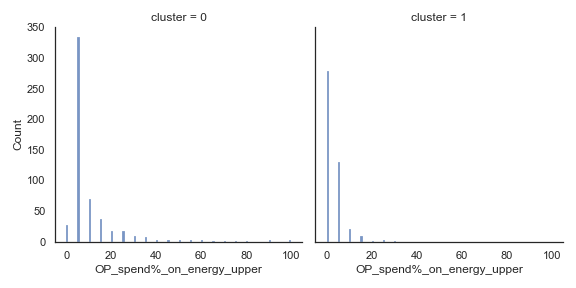

In [ ]:
## not running on kaggle platform
#import seaborn as sns; sns.set()

#sns.set_theme(style="darkgrid")
#sns.displot(energy_os_reshaped_cluster,
           # x="OP_spend%_on_energy_upper", 
           # col="cluster", 
           # binwidth=1, height=4, facet_kws=dict(margin_titles=True));

#### <span style='color:#808000'>Energy Activities</span>

In [ ]:
#energy_activities_reshaped.head()

In [ ]:
## Plot Number of responses to energy question 
## 'Select Which Energy \nrelated activities your 
## organization has undertaken'
## Responses encoded as: No reponse - 0, 
## No - 1, 
## Yes -2'

#energy_activities_reshaped

## reshape to plot
energy_activities_reshaped_chart = \
    pd.melt(energy_activities_reshaped.drop\
            (energy_activities_reshaped.columns[0:10],
             axis=1))

## group by variable and produce count of values for each
energy_activities_reshaped_heatmap = \
    energy_activities_reshaped_chart.\
    groupby('variable')['value'].value_counts().unstack()


##Annotated heatmaps
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set_theme()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(energy_activities_reshaped_heatmap, 
            annot=True, 
            fmt="d", 
            linewidths=.5, 
            ax=ax, 
            cmap='Blues')
ax.tick_params(axis='both', 
               which='major', 
               labelsize=14)
plt.xlabel("")
plt.ylabel("")
plt.title("""
            Number of corporations responding to question:
            Select Which Energy related activities 
            your organization has undertaken 
            No reponse - 0, No - 1, Yes - 2
          """,
         size=14)
plt.show();

>Electricity followed by fuel are most frequent energy related activities reported by the sample organizations. Cooling is the least reported energy related activity perhaps due to geographical representation. Subset of companies did not respond to question at all (encoded as 0).

In [ ]:
## adding cluster information
energy_activities_reshaped_cluster = \
    pd.merge(energy_activities_reshaped,
             corporations2020[['account_number',
                               'selected_tier',
                               'authority_types',
                               'cluster', 
                               'tickers']], 
             on='account_number')


## companies that did not respond
energy_activities_reshaped_cluster_NAN = \
    energy_activities_reshaped_cluster\
        [energy_activities_reshaped_cluster['electricity']==0]

## collect account references for further analysis
list_accounts_non_responding_C8_2 = energy_activities_reshaped_cluster_NAN['account_number'].tolist()
energy_activities_reshaped_cluster_NAN.tail(30)

#### <span style='color:#808000'>Energy consumption</span>

In [ ]:
#energy_consumption_reshaped.head(3).style.set_properties(**{'text-align': 'left'})
energy_consumption_reshaped_cluster = pd.merge(energy_consumption_reshaped,
                                              corporations2020[['account_number',
                                                                'cluster']],
                                              on='account_number')

**Consumption of energy by type from RENEWABLE sources**

In [ ]:
## Prepare data for ploting distribution of energy consumption
## by type from Renewable resources

columns_to_drop = np.r_[1,4:11]
energy_consumption_reshaped_density_plot = \
        energy_consumption_reshaped_cluster.\
            drop(energy_consumption_reshaped_cluster.columns\
                 [columns_to_drop], 
                 axis=1)

### melt all types of energy consumption from renewables
energy_consumption_reshaped_density_plot_1 = \
    pd.melt(energy_consumption_reshaped_density_plot,
            id_vars = ['account_number','primary_activity', 'cluster'])

In [ ]:
## list of variable to plot
energy_con_from_rn = ['C8.2a_C2MWh from renewable sources_Consumption of fuel (excluding feedstock)',
                  'C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired cooling',
                  'C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired electricity',
                  'C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired heat',
                  'C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired steam',
                  'C8.2a_C2MWh from renewable sources_Consumption of self-generated non-fuel renewable energy']

import seaborn as sns
#sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(y='variable', 
            x="value",
            data=energy_consumption_reshaped_density_plot_1\
                [energy_consumption_reshaped_density_plot_1['variable'].isin(energy_con_from_rn)])

sns.despine(offset=10, trim=True)

*Electricity from renewable sources, let us check outlier*

In [ ]:
## check outlier
energy_consumption_reshaped_density_plot.\
    sort_values(by='C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired electricity', 
                ascending=False)\
[['account_number','primary_activity','cluster',
  'C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired electricity']].head()

## account 8634 reported 939,184,788 MWh from renewable sources

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12,3))

plt.boxplot(energy_consumption_reshaped_density_plot\
            ['C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired electricity'],
            vert=False, patch_artist=True)

plt.xlabel("<-MWh_from_renewable_Consumption_electricity->", fontsize=14)

plt.text(11,1.3, "The extreme value represents account 8634 from Other non-ferrous ore mining", 
         fontsize=14,
        bbox={'facecolor': 'yellow', 'edgecolor': 'yellow', 'alpha': 0.2, 'pad': 8});

In [ ]:
## it is highly unlikely value
# (939184788/energy_consumption_reshaped_density_plot['MWh_from_renewable_Consumption_electricity'].sum())*100
## 71% of total reported consumed electricity that came from Renewable Sources reported by sample
corporations2020[corporations2020['account_number']==8634]

In [ ]:
## droping outlier acc 8634
data10 = \
    energy_consumption_reshaped_density_plot\
        [energy_consumption_reshaped_density_plot['account_number']!=8634]\
        [['primary_activity','cluster', 'primary_industry',
          'C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired electricity']]

data10.groupby(['primary_activity','primary_industry','cluster']).\
    agg(sum_ = pd.NamedAgg(column=\
                           'C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired electricity',
                           aggfunc=np.sum),
        mean_ = pd.NamedAgg(column=\
                            'C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired electricity', 
                            aggfunc=np.mean),
        median_ = pd.NamedAgg(column=\
                              'C8.2a_C2MWh from renewable sources_Consumption of purchased or acquired electricity', 
                              aggfunc=np.median)).\
                        nlargest(40, 'sum_').\
                            reset_index().\
                                round(decimals=0).\
                                    style.bar(subset=['sum_','mean_','median_'], color='#d65f5f')

*Fuel from renewable sources*

In [ ]:
## check outlier
energy_consumption_reshaped_density_plot.\
    sort_values(by='C8.2a_C2MWh from renewable sources_Consumption of fuel (excluding feedstock)', 
                ascending=False)\
[['account_number','primary_activity','cluster',
  'C8.2a_C2MWh from renewable sources_Consumption of fuel (excluding feedstock)']].head(20)

## account 9352 reported 96,670,410.47 MWh of consumed fuel from renewable sources

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12,3))

plt.boxplot(energy_consumption_reshaped_density_plot\
            ['C8.2a_C2MWh from renewable sources_Consumption of fuel (excluding feedstock)'],
            vert=False, patch_artist=True)

plt.xlabel("<-MWh_from_renewable_Consumption_electricity->", fontsize=14)

plt.text(11,1.3, "The extreme value represents account 9352 from Paper packaging activity", 
         fontsize=14,
        bbox={'facecolor': 'yellow', 'edgecolor': 'yellow', 'alpha': 0.2, 'pad': 8});

The distribution of consumed fuel from renewable resources is less skewed, and it is noticable that Paper packaging and Pulp & paper mills are largest contributors to this type of consumption.

**Consumption of energy by type from NON RENEWABLE sources**

In [ ]:
## list of variable to plot
energy_con_from_NONrn = ['C8.2a_C3MWh from non-renewable sources_Consumption of fuel (excluding feedstock)',
       'C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired cooling',
       'C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired electricity',
       'C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired heat',
       'C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired steam',
       'C8.2a_C3MWh from non-renewable sources_Consumption of self-generated non-fuel renewable energy']

import seaborn as sns
#sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(y='variable', 
            x="value",
            data=energy_consumption_reshaped_density_plot_1\
                [energy_consumption_reshaped_density_plot_1['variable'].isin(energy_con_from_NONrn)])

sns.despine(offset=10, trim=True)

*Electricity consumption from Non renewable sources*

In [ ]:
## check outlier
energy_consumption_reshaped_density_plot.\
    sort_values(by='C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired electricity', 
                ascending=False)\
[['account_number','primary_activity','cluster',
  'C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired electricity']].head()

In [ ]:
## want to check all info on these "outliers"
outliers_electricity_non_rn = [3848, 46940, 8634, 699, 35322]

pd.merge(general[general['account_number'].isin(outliers_electricity_non_rn)],
         reporting_period_reshaped[reporting_period_reshaped['account_number']\
                                   .isin(outliers_electricity_non_rn)]\
         [['account_number','C0.2_C1Start date_Reporting year']], on='account_number')
         
## all (outliers) organization report for year 2019, so dates are not reason

## at least '3848' reported figure is unlikely

In [ ]:
## droping outlier acc 8634
data12 = \
    energy_consumption_reshaped_density_plot\
        [energy_consumption_reshaped_density_plot['account_number']!=3848]\
        [['primary_activity','cluster', 'primary_industry',
          'C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired electricity']]

data12.groupby(['primary_activity','primary_industry','cluster']).\
    agg(sum_ = pd.NamedAgg(column=\
                           'C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired electricity',
                           aggfunc=np.sum),
        mean_ = pd.NamedAgg(column=\
                            'C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired electricity', 
                            aggfunc=np.mean),
        median_ = pd.NamedAgg(column=\
                              'C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired electricity', 
                              aggfunc=np.median)).\
                        nlargest(20, 'sum_').\
                            reset_index().\
                                round(decimals=0).\
                                    style.bar(subset=['sum_','mean_','median_'], color='#d65f5f')

In [ ]:
(2364460000 + 700963342)/(data12['C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired electricity']\
                          .sum())*100

print("""
Checking information on account 46940 on the company website, it appears 
more accurate classification of nature of their business is Manufacturing of industrial solutions. 
This might explain inconsistency with such high reported consumption of electricity 
""")
print(2364460000/(data12['C8.2a_C3MWh from non-renewable sources_Consumption of purchased or acquired electricity'].sum())*100, '% of total and printing services as primary activity')

*Fuel consumption from Non renewable sources*

In [ ]:
## check outlier
energy_consumption_reshaped_density_plot.\
    sort_values(by='C8.2a_C3MWh from non-renewable sources_Consumption of fuel (excluding feedstock)', 
                ascending=False)\
[['account_number','primary_activity','cluster',
  'C8.2a_C3MWh from non-renewable sources_Consumption of fuel (excluding feedstock)']].head()

In [ ]:
## it is more likely than not that reported figures are good estimates, 
## as all accounts are in category of Environment Sensitve Industries.

**Total Energy Consumption from renewable and nonrenewable sources**

In [ ]:
## Drop outliers as discussed above,
## These values are likely to be errors and will
## bias analysis

## Organizations that did not respond to questionnaire: 
list_accounts_non_responding_C8_2
unlikely_high_values_C8_2a = [8634,3848,46940]
accounts_to_drop_energy_C_8_2a = list_accounts_non_responding_C8_2 + unlikely_high_values_C8_2a

#energy_consumption_reshaped_density_plot.columns

In [ ]:
## list of variable to plot
energy_con_Total = ['C8.2a_C2MWh from renewable sources_Total energy consumption',
       'C8.2a_C3MWh from non-renewable sources_Total energy consumption',
       'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption']

energy_consumption_reshaped_density_plot_1_dropped_acc = \
    energy_consumption_reshaped_density_plot_1\
    [energy_consumption_reshaped_density_plot_1\
     ['account_number'].isin(accounts_to_drop_energy_C_8_2a) == False]


import seaborn as sns
#sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(y='variable', 
            x="value",
            data=energy_consumption_reshaped_density_plot_1\
                [energy_consumption_reshaped_density_plot_1['variable'].isin(energy_con_Total)])

sns.despine(offset=10, trim=True)

In [ ]:
## drop outliers
energy_consumption_reshaped_density_plot_drop_acc = \
    energy_consumption_reshaped_density_plot\
    [energy_consumption_reshaped_density_plot['account_number']\
     .isin(accounts_to_drop_energy_C_8_2a) == False]

## drop very small values <100
energy_consumption_reshaped_density_plot_drop_acc = \
    energy_consumption_reshaped_density_plot_drop_acc\
    [energy_consumption_reshaped_density_plot_drop_acc\
     ['C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption']>100]


energy_consumption_reshaped_density_plot_drop_acc.\
    sort_values(by='C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption', 
                ascending=False)\
[['account_number','primary_activity','cluster',
  'C8.2a_C2MWh from renewable sources_Total energy consumption',
 'C8.2a_C3MWh from non-renewable sources_Total energy consumption',
 'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption']].head(10)

In [ ]:
import squarify
plt.figure(figsize=(15, 8))

data14 = energy_consumption_reshaped_density_plot_drop_acc

data15 = data14.groupby('primary_activity').\
    agg(MWh_Total_energy_consumption = \
        pd.NamedAgg(column=\
                    'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption',
                           aggfunc=np.sum),
        mean_ = \
        pd.NamedAgg(column=\
                    'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption', 
                            aggfunc=np.mean)).\
        nlargest(10, 'MWh_Total_energy_consumption').\
        reset_index().round(decimals=0)


#(data15['MWh_Total_energy_consumption'].sum()) / (data14['C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption'].sum())

labels = data15['primary_activity']

colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

squarify.plot(sizes=(data15['MWh_Total_energy_consumption']),label=labels, color=colors)

plt.title("Ten top activities by energy consumption reported 68% of total energy consumed MWh",
         fontsize=14);

In [ ]:
data16 = data14.groupby('primary_activity').\
    agg(MWh_Total_EC_from_Renewable_sources = \
        pd.NamedAgg(column=\
                    'C8.2a_C2MWh from renewable sources_Total energy consumption',
                           aggfunc=np.sum),
        mean_ = \
        pd.NamedAgg(column=\
                    'C8.2a_C2MWh from renewable sources_Total energy consumption', 
                            aggfunc=np.mean)).\
        nlargest(10, 'MWh_Total_EC_from_Renewable_sources').\
        reset_index().round(decimals=0)

In [ ]:
data14['Perc_of_renewable_sourcing'] = data14\
['C8.2a_C2MWh from renewable sources_Total energy consumption']/data14['C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption'] *100

In [ ]:
data14[['account_number','primary_activity','cluster',
        'C8.2a_C2MWh from renewable sources_Total energy consumption',
        'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption',
        'Perc_of_renewable_sourcing']].\
        nlargest(20,'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption').\
        style.bar(subset=['C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption',
                          'Perc_of_renewable_sourcing'], color='darkorange')

In [ ]:
#Interesting exception Paper packaging companies
#general[general['primary_activity']=='Paper packaging']

###  <span style='color: #001A8C'>Regression of direct CO2eq mt emissions on total energy consumed MWh</span>

**Global Scope1 emissions reported by corporations**

In [ ]:
### related datasets
## r_corp_cl_2020_clean - original ds prior cleaning and reshaping, contains original info
## general - contains general description of corporations
## reporting_period_reshaped - subset contains period reporting dates
## corporations2020 - reshaped with clusters information added
## energy_consumption_reshaped
## scope1
## intensity_metrics_reshaped

In [ ]:
data_C6_1_C1 = scope1[scope1[scope1.columns[-1]]!=0]
data_C6_1_C1.groupby('primary_activity').\
    agg(sum_CO2e_Scope1_mt = pd.NamedAgg(column=scope1.columns[-1], aggfunc=np.sum),
        mean_ = pd.NamedAgg(column=scope1.columns[-1], aggfunc=np.mean),
        median_ = pd.NamedAgg(column=scope1.columns[-1], aggfunc=np.median)).\
                        nlargest(30, 'sum_CO2e_Scope1_mt').\
                            reset_index().\
                                round(decimals=0).\
                                    style.bar(subset=['sum_CO2e_Scope1_mt','mean_','median_'], color='#ada49a')

In [ ]:
## will sum up first 30 groups of activities
scope1_top_30 = data_C6_1_C1.groupby('primary_activity').\
    agg(sum_ = pd.NamedAgg(column=scope1.columns[-1], aggfunc=np.sum),
        mean_ = pd.NamedAgg(column=scope1.columns[-1], aggfunc=np.mean),
        median_ = pd.NamedAgg(column=scope1.columns[-1], aggfunc=np.median)).\
                        nlargest(30, 'sum_').\
                            reset_index().\
                                round(decimals=0)

scope1_top_30['sum_'].sum()
scope1_top_30
print('30 groups of activities contribute ',
      scope1_top_30['sum_'].sum()/ data_C6_1_C1[scope1.columns[-1]].sum() * 100,
      '% of reported Scope 1 CO2e mt emissions')

In [ ]:
#### this code does not run on kaggle platform

## filter organizations in this 40 groups as subset for analysis
#activities = scope1_top_30.primary_activity.unique()
#largest_by_scope1 = data_C6_1_C1[data_C6_1_C1['primary_activity'].isin(activities)]
#largest_by_scope1 = \
    #largest_by_scope1.sort_values(by='C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)_Reporting year')

#import seaborn as sns
#fig = plt.figure(figsize=(12,6))
#ax = sns.kdeplot(largest_by_scope1\
                 #['C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)_Reporting year'],
                 #hue=largest_by_scope1['primary_industry'],
                 #multiple='fill')

#ax.set_title("Density of reported Scope 1 CO2e emissions (mt) aggregated by industry",
            #fontsize=14)
#ax.set_xlabel("")
#plt.savefig('scope1_plot.png')
#plt.show();

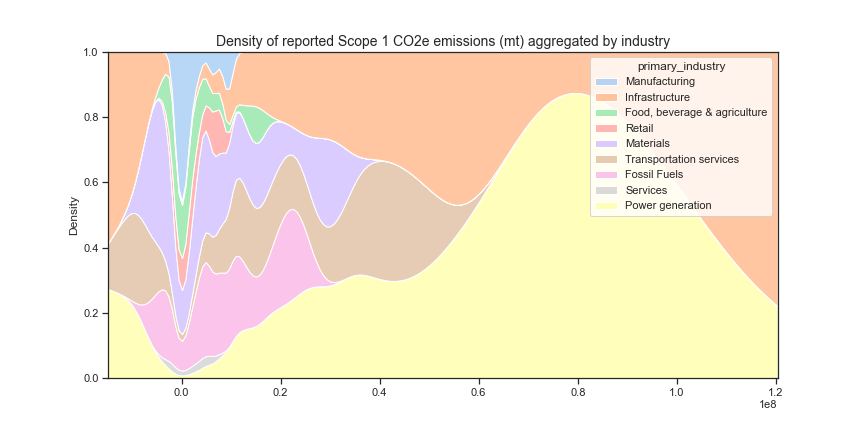

**Energy Consumption and Emissions**

In [ ]:
energy_and_direct_emissions = \
    pd.merge(energy_consumption_reshaped_cluster\
             [['account_number',
              'organization',
              'primary_activity',
              'primary_industry',
               'cluster',
              'C8.2a_C2MWh from renewable sources_Total energy consumption',
              'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption']],
            scope1[['account_number',
                    'C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)_Reporting year']],
            on='account_number')

In [ ]:
data20 = energy_and_direct_emissions.sort_values\
    (by='C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)_Reporting year',
     ascending=False).head(15).\
    style.bar(subset=['C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)_Reporting year',
                      'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption'], 
              color='#e7ed95')

data20

#### <span style='color:#808000'>Regression model </span>

In [ ]:
# importing necessary libraries 
from sklearn import linear_model 
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error 
from sklearn.model_selection import train_test_split

# prepare data, drop list of accounts likely errors and non-reported
accounts_to_drop_energy_C_8_2a
df = energy_and_direct_emissions\
    [energy_and_direct_emissions['account_number'].\
         isin(accounts_to_drop_energy_C_8_2a)==False]

df = df.rename({'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption': 'TotalEnergyConsumedMWh',
               'C6.1_C1Gross global Scope 1 emissions (metric tons CO2e)_Reporting year': 'DirectEmissionsCO2e_mt'},axis=1)


# features into variables 
energy = df[['TotalEnergyConsumedMWh']] 
co2eq = df[['DirectEmissionsCO2e_mt']]

In [ ]:
# spliting data in train and test with train_test_split 
energy_treino, energy_test, co2eq_treino, co2eq_test = train_test_split(energy, co2eq, test_size=0.2, random_state=42)

# ploting the correlation between features on train dataset
plt.scatter(energy_treino, co2eq_treino, color='#2d3001')
plt.xlabel('energy')
plt.ylabel('co2eq direct emission')
plt.show()

In [ ]:
# creating a linear regression model
model_ee = linear_model.LinearRegression()
model_ee.fit(energy_treino, co2eq_treino)
print(f'(A) intercept: {model_ee.intercept_} | (B) regression coefficient: {model_ee.coef_}')

In [ ]:
# run on TEST dataset
plt.scatter(energy_test, co2eq_test, color='#27112e')
plt.plot(energy_test, model_ee.coef_[0][0]*energy_test + model_ee.intercept_[0], '-r')
plt.ylabel('Direct CO2eq emissions mt')
plt.xlabel('Energy consumption MWh')
plt.show()

In [ ]:
#check the accuracy of model
# The coefficients
co2eq_pred = model_ee.predict(co2eq_test)
print('Coefficients: \n', model_ee.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(co2eq_test, co2eq_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(co2eq_test, co2eq_pred))

>Regression model explains about 26% of variations, not very good result. As it is known fact that energy consumption drives increase in emissions, one can conclude that data on which model is run is not very accurate.

### Conclusion and KPI proposal <a class="anchor" id="kpi"></a>

- It is possible that improved classification of survey participants by nature of their business will facilitate better analysis of their impact on the sustainability issues. Companies that did not respond to many questions might be small with limited budgets, unable to undertake costly measurement or employ specialist consultants. More applicable questionnaires scaled to main characteristic of segmented groups could improve quality of survey data and reduce 'non response' bias.


- As it stands reported emission figures are not very reliable, and there is more certainty in reported energy consumption. Hence building performance metric on this feature could be more indicative of the **Decarbonization effort** undertaken by organizations. One method to reduce emissions without compromising our living conditions and industrial progress is to increase use of energy from renewable sources. Indead many organizations committed to 100% renewable energy sourcing, including Google global operations. 

**<span style='color: #001A8C'>Commitment to decarbonization measured by the ratio of Total consumed Energy obtained from Renewable sources to the Total Energy consumed in the reporting period.** This measure is scalable to different entities, ESI industries with 'higher' energy bills and greater impact on 'decarbonization' will be penalized by 'low ratio'. Derived ratios then can be compared among corporations with similar characteristics to benchmark best performance or to identify unlikely outlier.</span>**

**Run example**

In [ ]:
test_data = data14[['account_number',
                    'primary_activity',
                    'primary_industry',
                    'cluster',
                    'C8.2a_C2MWh from renewable sources_Total energy consumption',
                    'C8.2a_C4Total (renewable and non-renewable) MWh_Total energy consumption',
                    'Perc_of_renewable_sourcing']]

#test_data.sort_values(by='Perc_of_renewable_sourcing', ascending=False)

In [ ]:
## draw from sample of accounts
import random  
from random import sample
random.seed(42) 
random.sample(list(test_data['account_number']), 1)

In [ ]:
test_data[test_data['account_number']==56728]

The ratio is 15%, how good it compares to other organizations with similar charactetistics?

In [ ]:
test_data[(test_data['primary_activity']=='Automobiles') &
          (test_data['primary_industry']=='Manufacturing')]['Perc_of_renewable_sourcing'].describe()

Our sample account is an average performer excluding outlier reported 100% 

In [ ]:
corporations2020[corporations2020['primary_activity']=='Passenger airlines']['cluster']

In [ ]:
pd.merge(intensity_metrics_reshaped[['account_number', 
                            'C6.10_C4Metric denominator: Unit total_1', 
                            'C6.10_C3Metric denominator_1']],corporations2020[['account_number',
                                                                              'organization',
                                                                              'primary_activity','cluster']],
         on='account_number').nlargest(20,'C6.10_C4Metric denominator: Unit total_1')

<center>End of notebook</center>